In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [9]:
import pandas as pd
import numpy as np
import sys
import os
import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline

#Color definition
Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

from IPython.core.display import display, HTML
display(HTML('<style>.container { width:98% !important; }</style>'))

In [37]:
# path = '/scratch/bakeoff_configs6_results2014/resnet_18_35/'
# pred = np.load(path+'resnet_18_35.npy')
# test = pd.read_csv('/run/shm/AIA_2014_256/test.csv')

path = '/scratch/bakeoff_configs8_results20112014/anet_2_bn_0/'
pred = np.load(path+'anet_2_bn_0_us.npy')
test = pd.read_csv('/run/shm/AIA_256_20112014/test.csv')

modelname = 'anet_2_bn_0'

patho = '/home/andres/testout/'


import matplotlib.pylab as plt
%matplotlib inline 
plt.ioff()
plt.switch_backend('agg')


plt.rcParams['figure.figsize']=(9,5)
plt.rcParams['font.size']=20
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.rcParams['axes.grid']=True
plt.rcParams['axes.linewidth']=1.0
plt.rcParams['grid.alpha']=0.3
plt.rcParams['axes.spines.bottom']=True
plt.rcParams['axes.spines.left']=True
plt.rcParams['axes.spines.right']=True
plt.rcParams['axes.spines.top']=True
plt.rcParams['legend.fontsize']='small'
plt.rcParams['axes.prop_cycle']=plt.cycler('color',plt.cm.gist_stern(np.linspace(0,1,9)))
plt.rcParams['savefig.dpi'] = 150



lines = [0,1,2,3,4,5,6,7,8,9,10,11,12,14]
print('We are not including line 13 in the metrics!')

We are not including line 13 in the metrics!


In [4]:
test['rowname'] = np.array(test['row_name'],dtype=int)

eve = np.load('/data/NASAFDL2018/SpaceWeather/Team1-Meng/EVE/np/irradiance.npy')
iso = np.load('/data/NASAFDL2018/SpaceWeather/Team1-Meng/EVE/np/iso.npy')
logT = np.load('/data/NASAFDL2018/SpaceWeather/Team1-Meng/EVE/np/logt.npy')
name = np.load('/data/NASAFDL2018/SpaceWeather/Team1-Meng/EVE/np/name.npy')
wavelength = np.load('/data/NASAFDL2018/SpaceWeather/Team1-Meng/EVE/np/wavelength.npy')


eve = eve[test['rowname'].values,:]
iso = iso[test['rowname'].values]
eve = eve[:,lines]
logT = logT[lines]
name = name[lines]
wavelength = wavelength[lines]

error = (eve-pred)/eve


goodrows = np.array(np.where(eve[:,0] != -1.0))
eve = eve[goodrows,:]
pred = pred[goodrows,:]
error = error[goodrows,:]
iso = iso[goodrows]

rows = eve.shape[1]
eve = np.reshape(eve,[rows,14])
eve = eve.byteswap().newbyteorder()
pred = np.reshape(pred,[rows,14])
error = np.reshape(error,[rows,14])
error = error.byteswap().newbyteorder()
iso   = np.reshape(iso,rows)


mean_error = (error*eve).mean(axis=0)

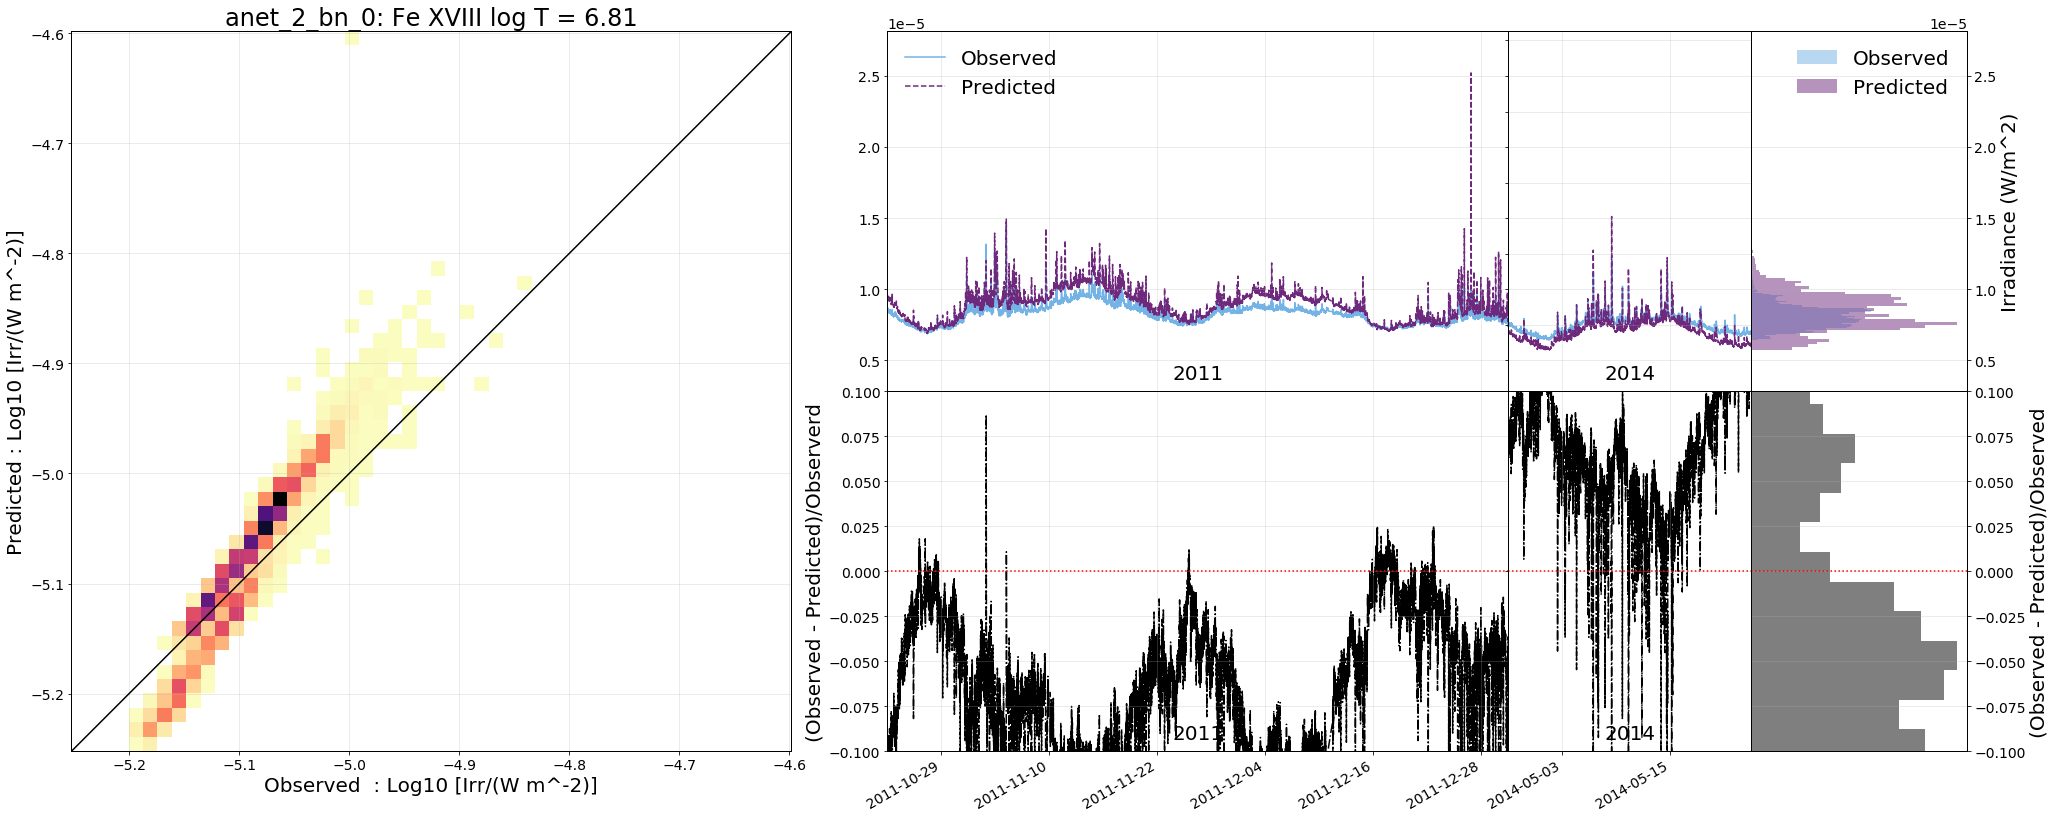

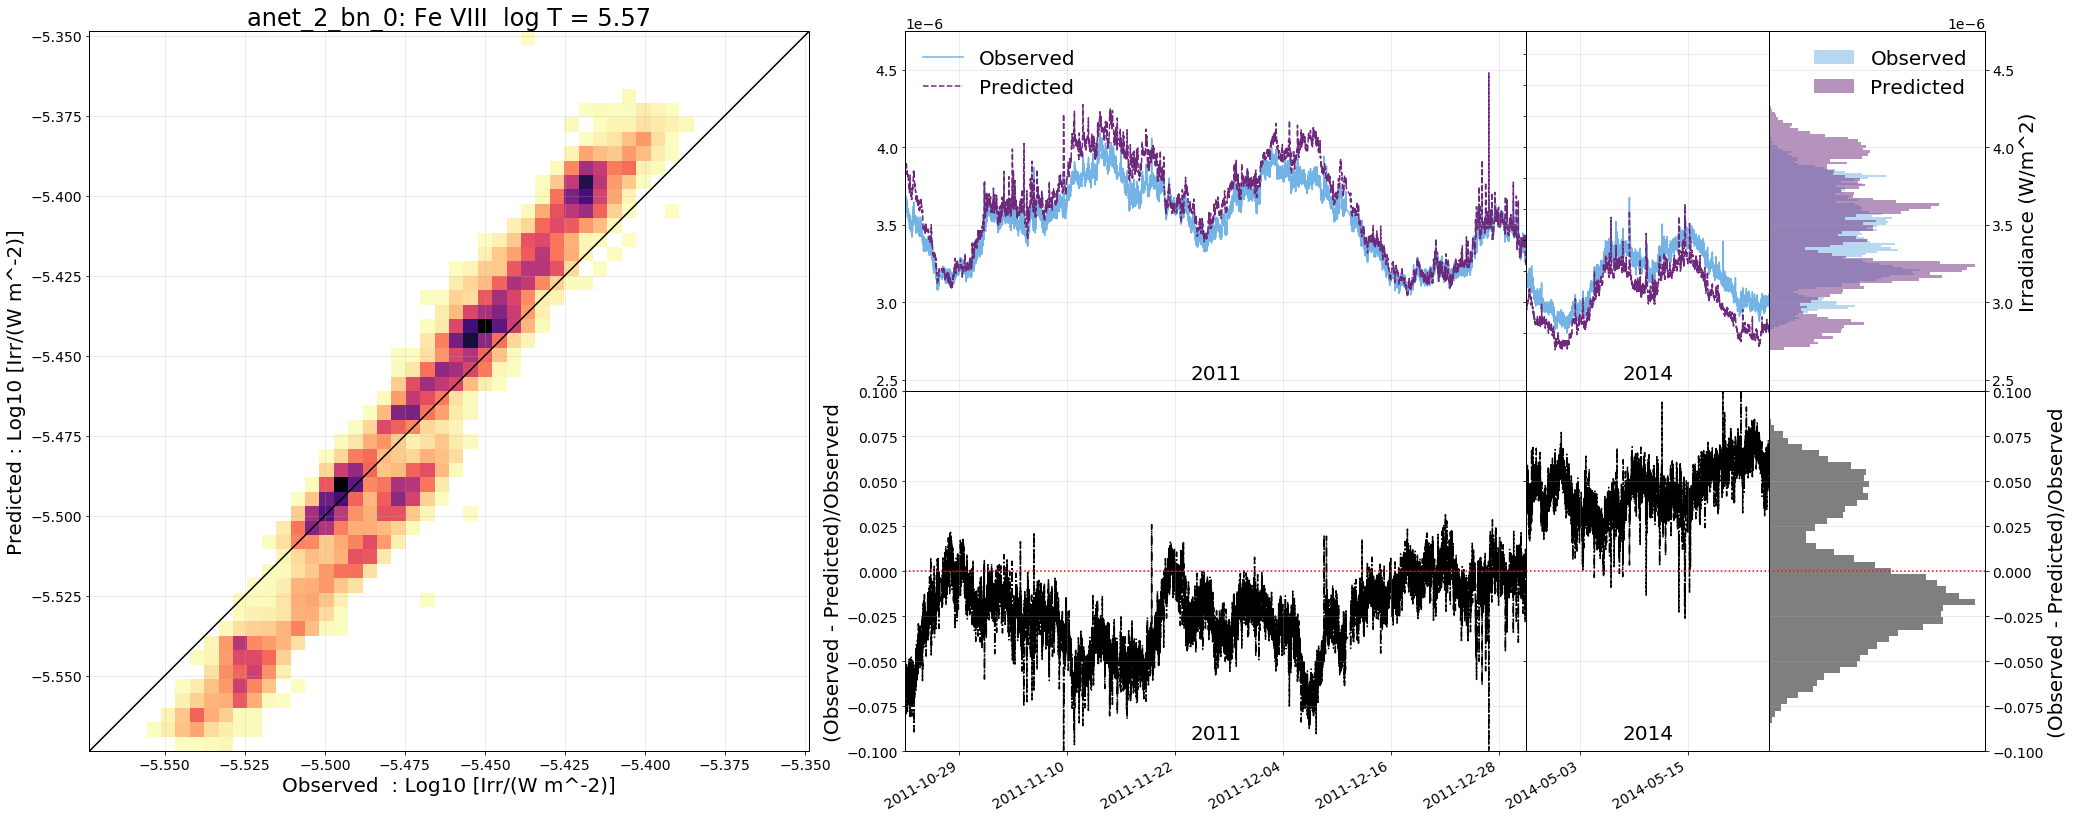

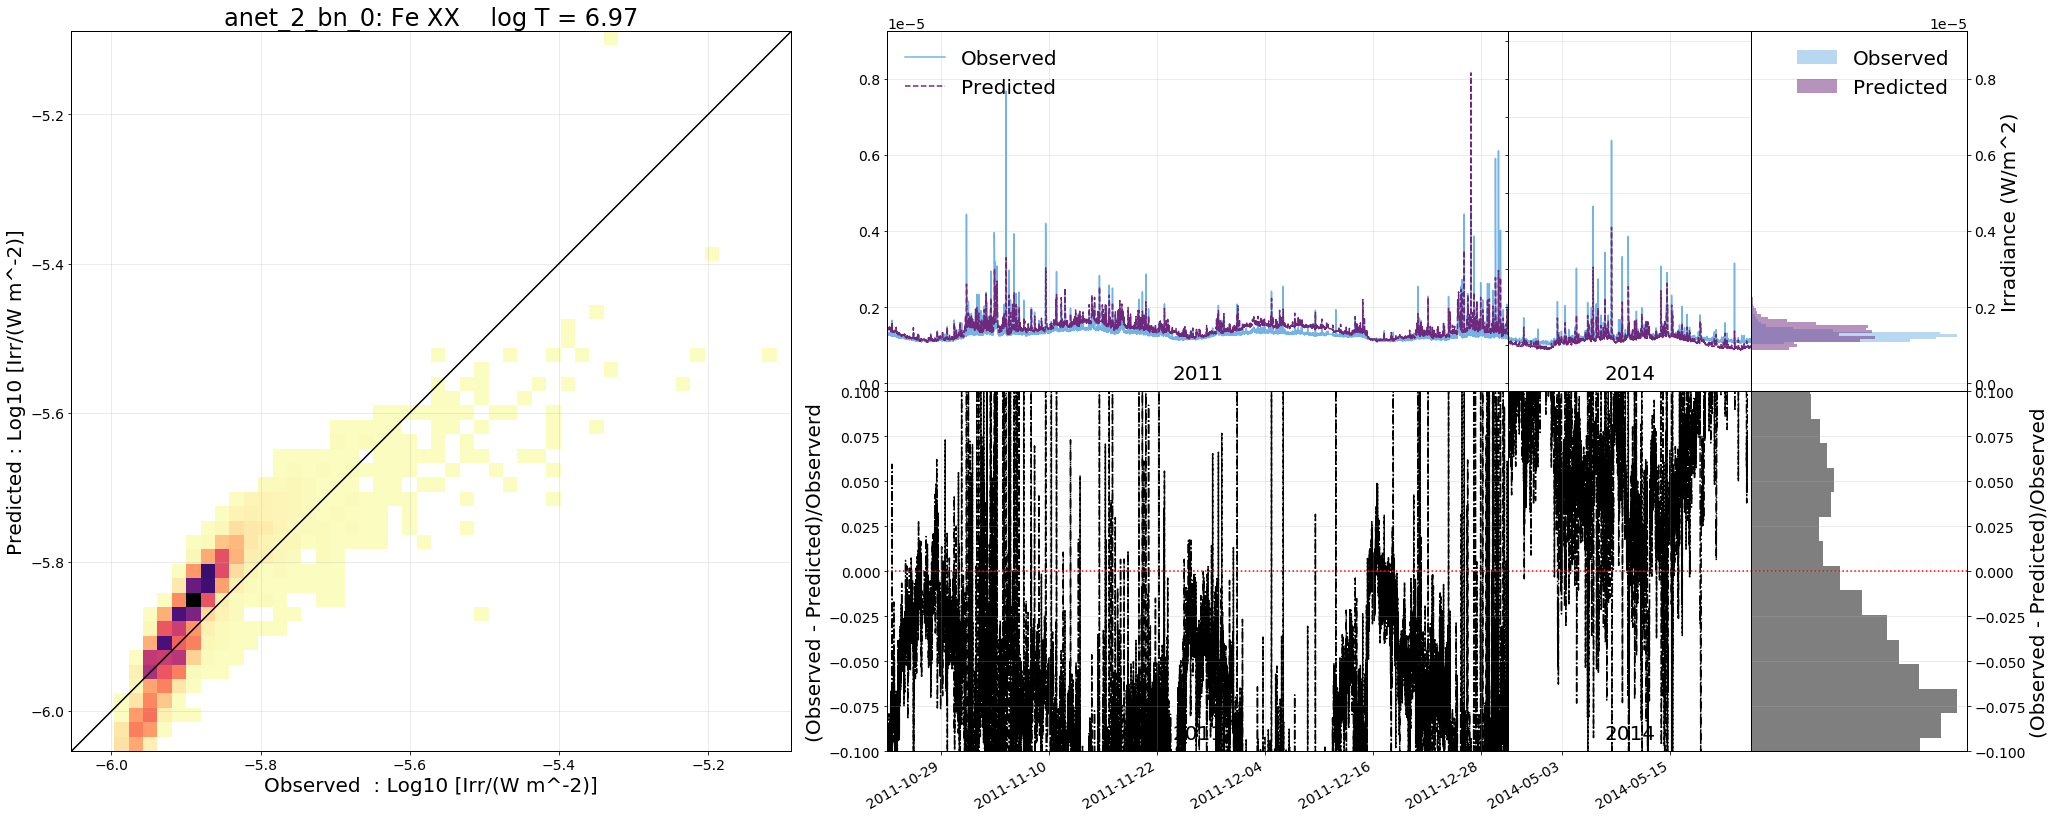

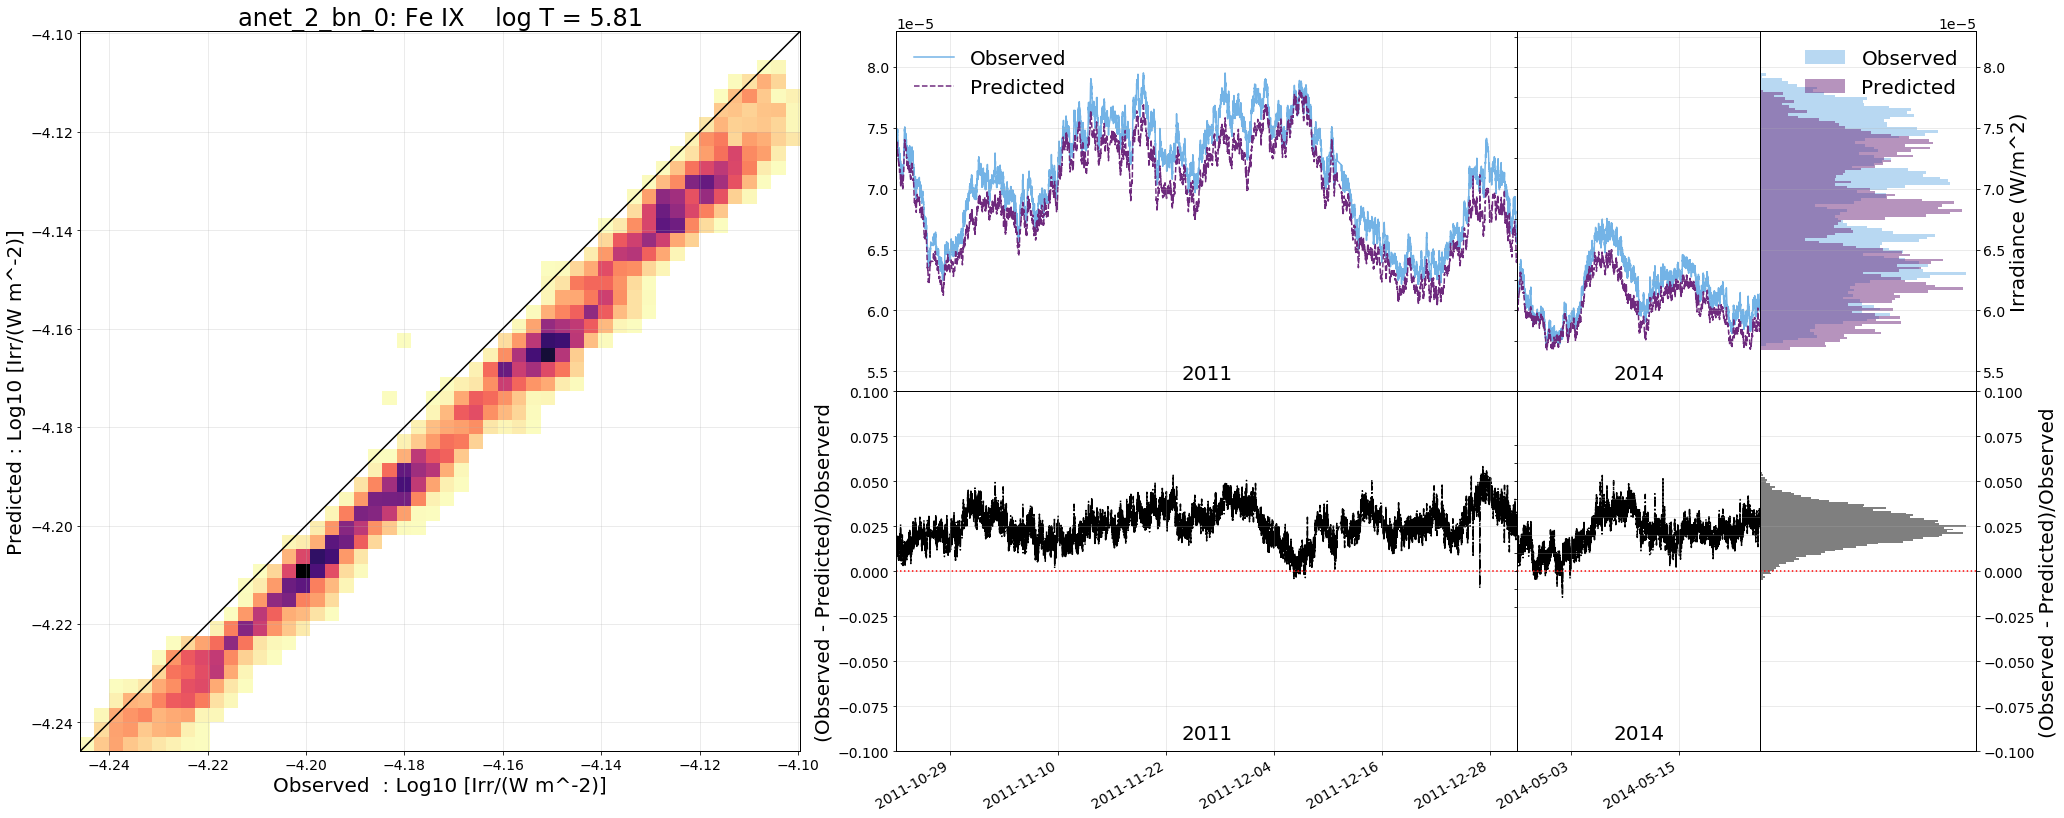

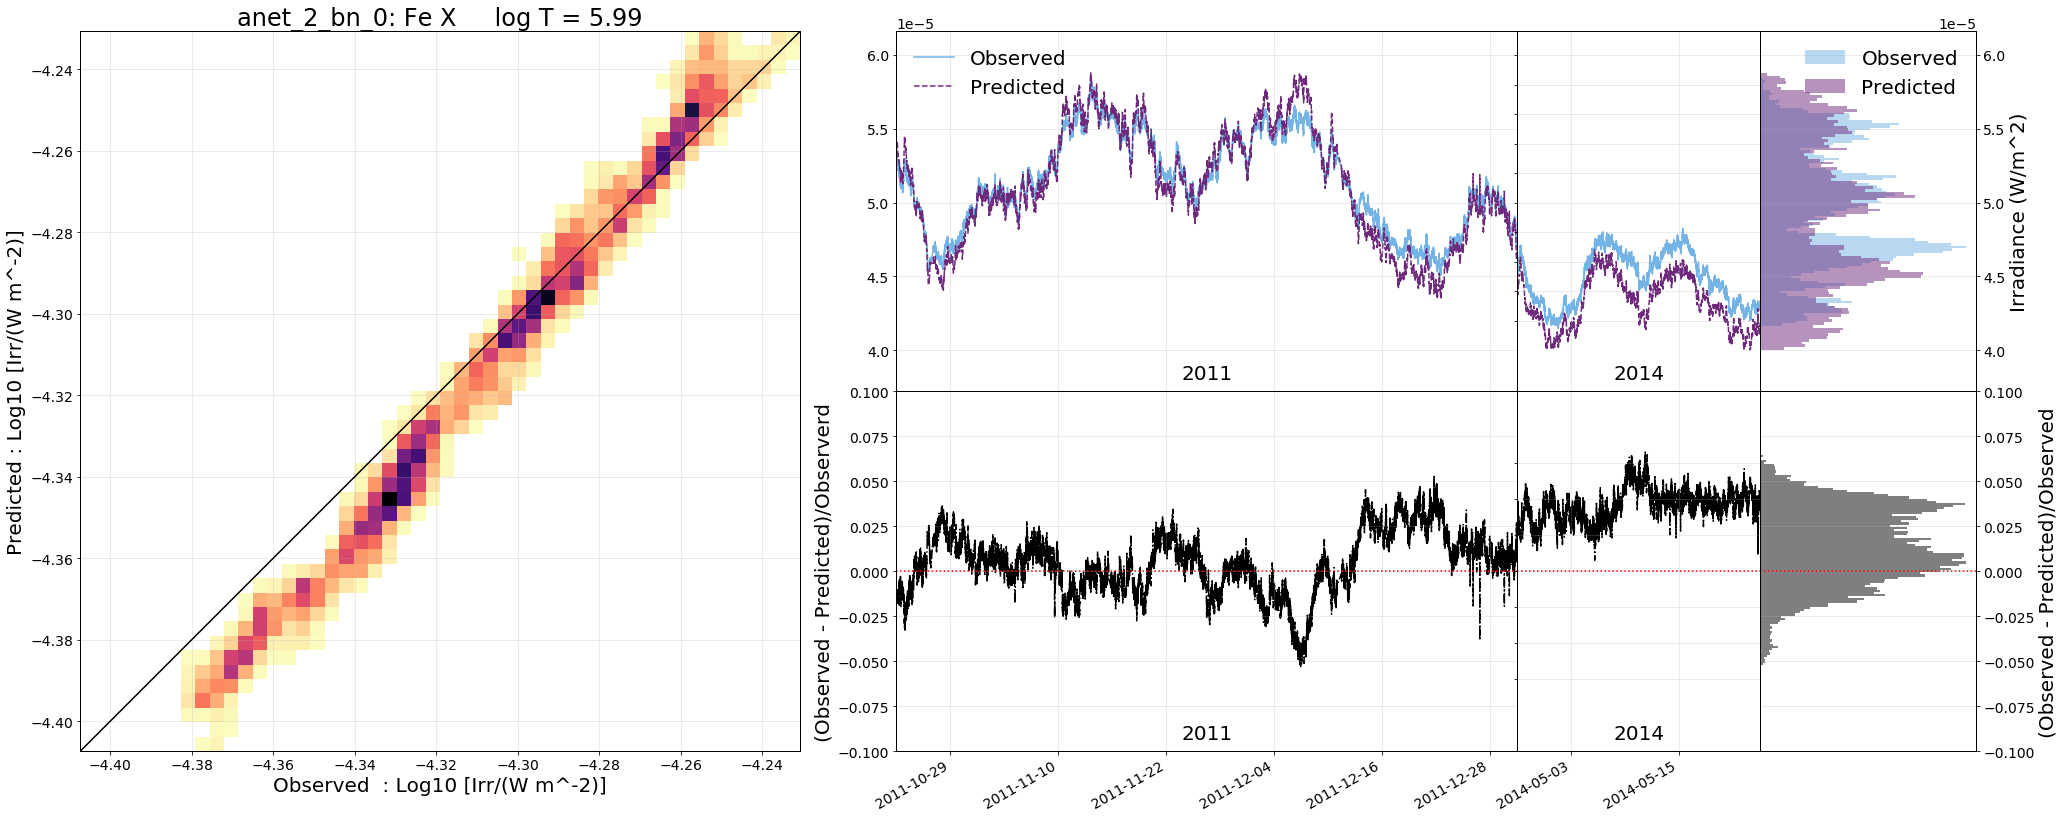

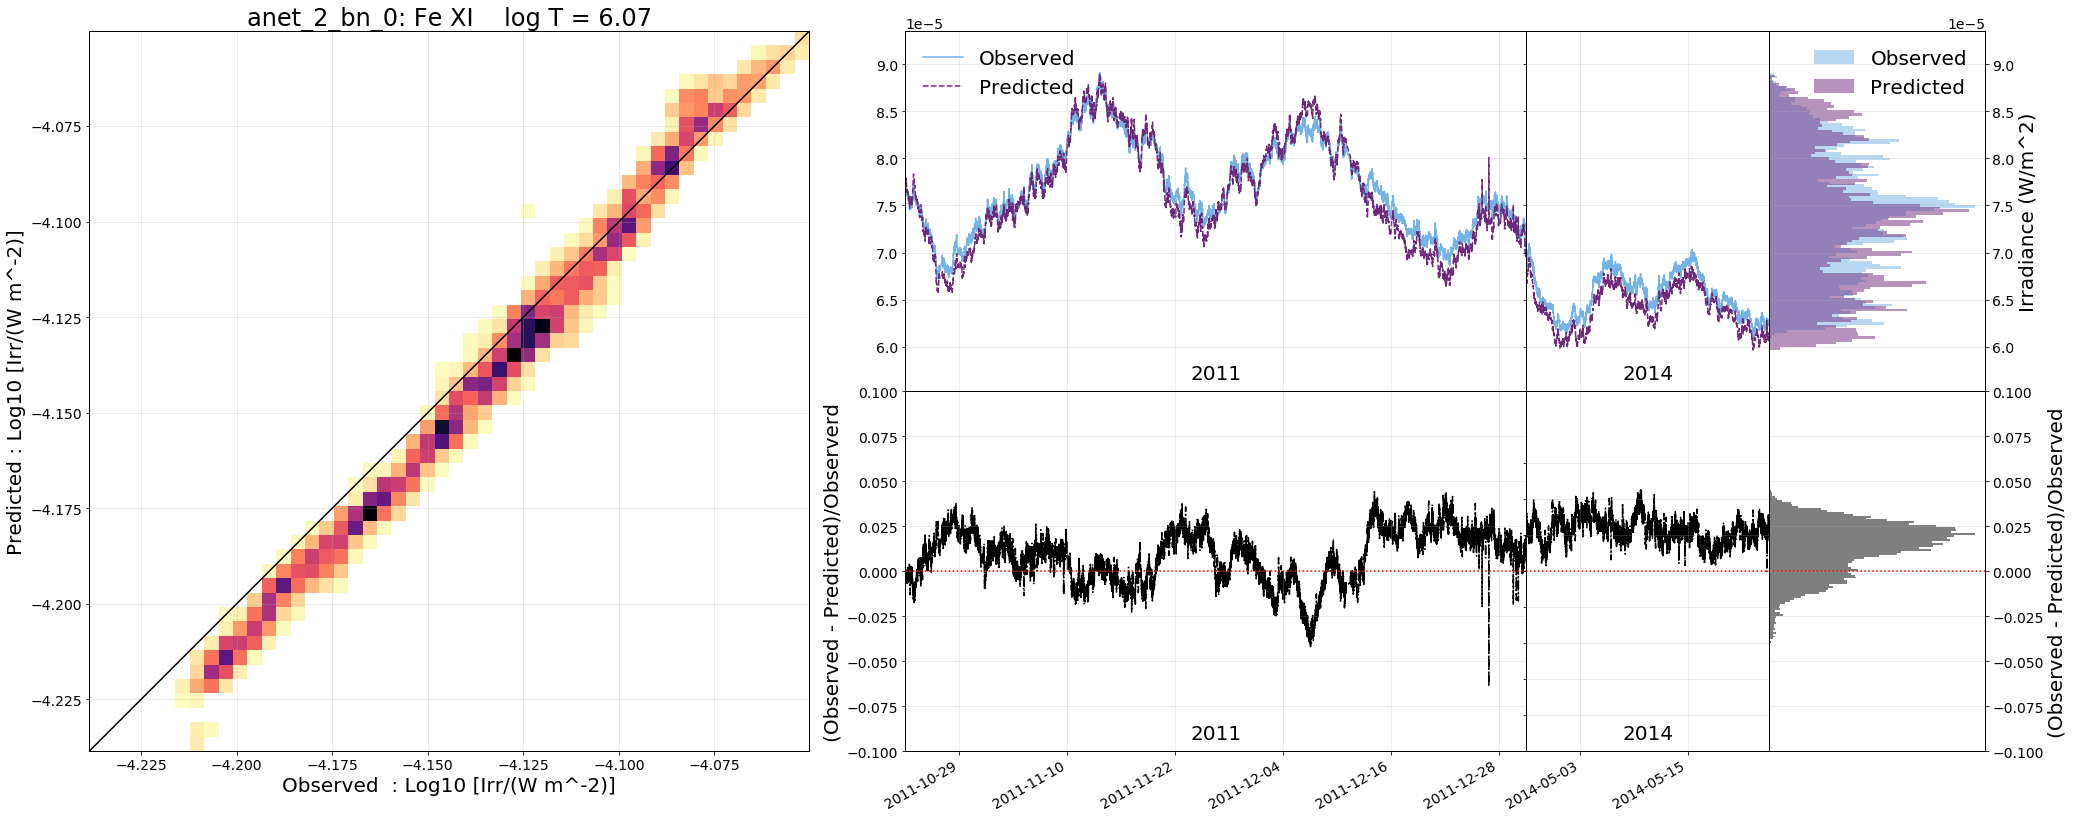

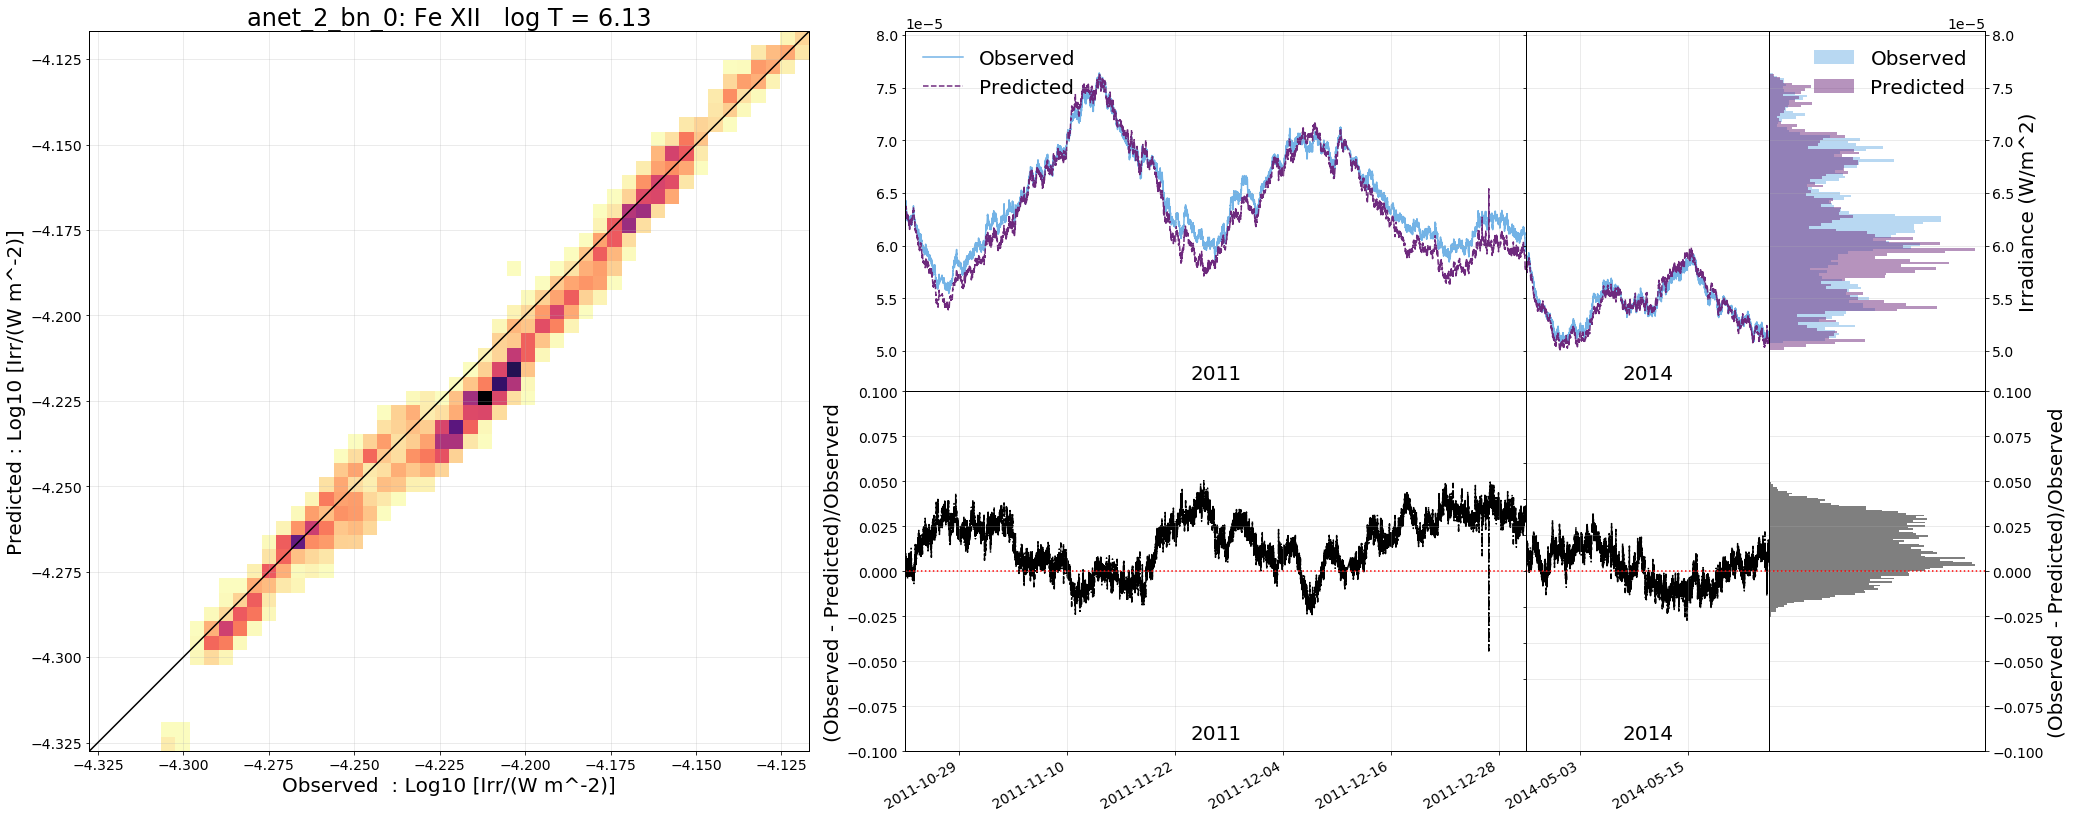

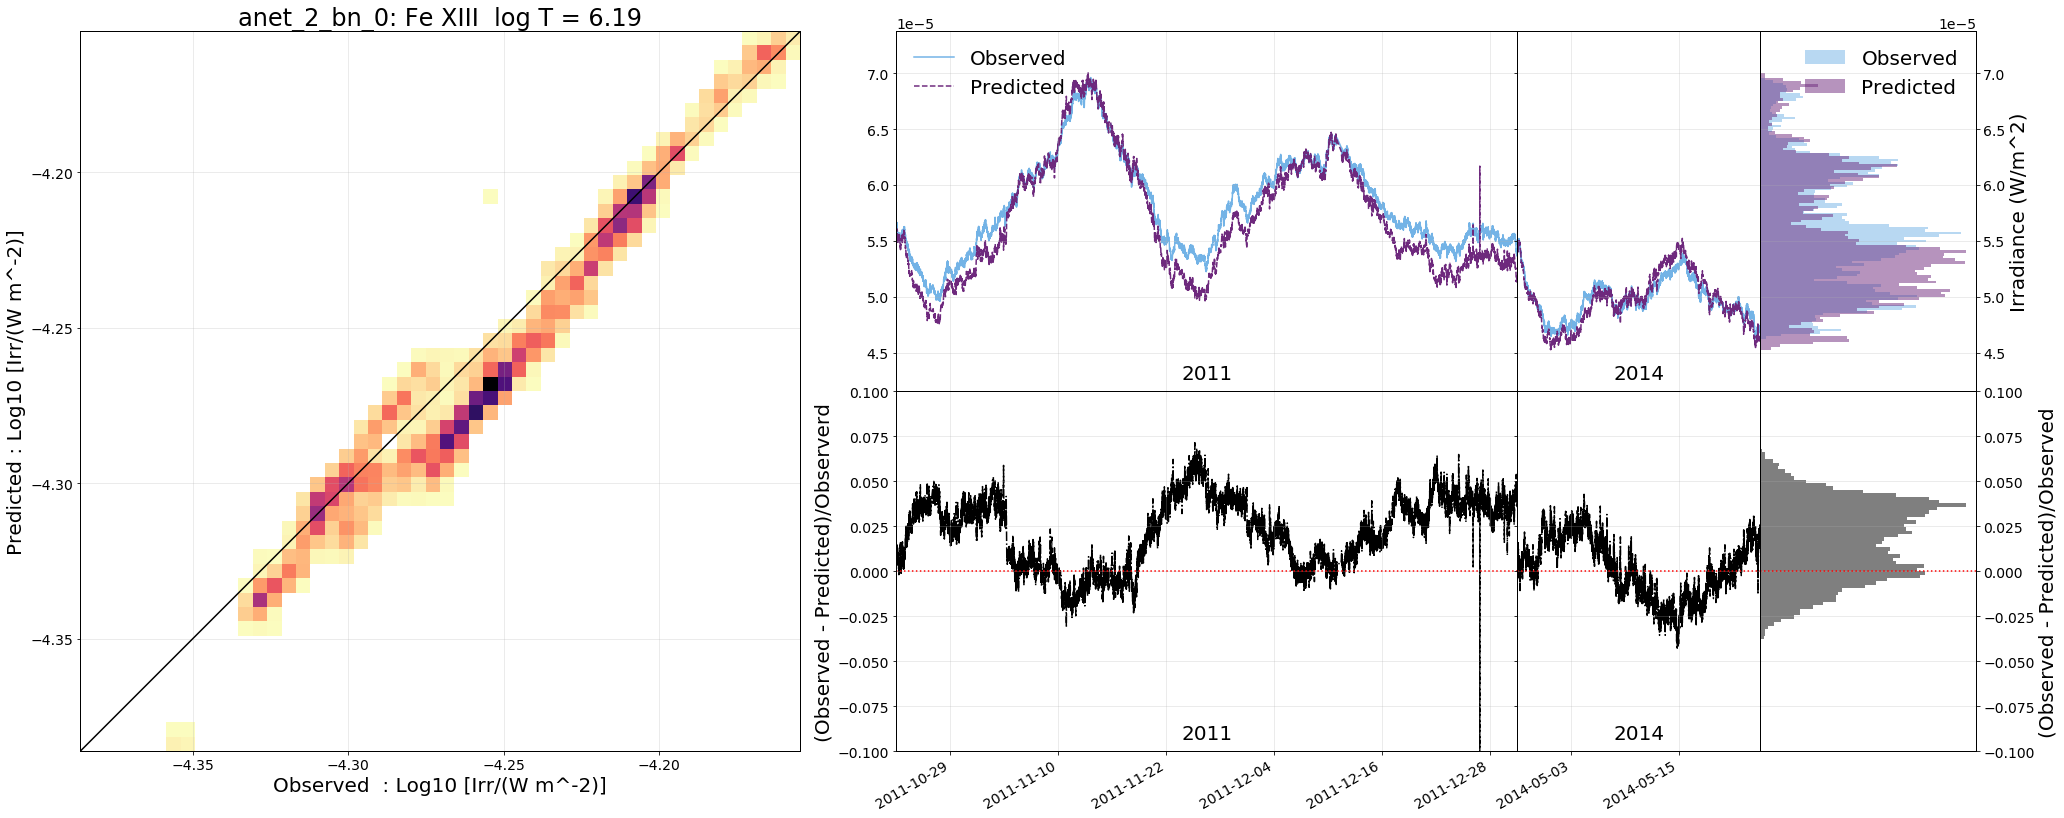

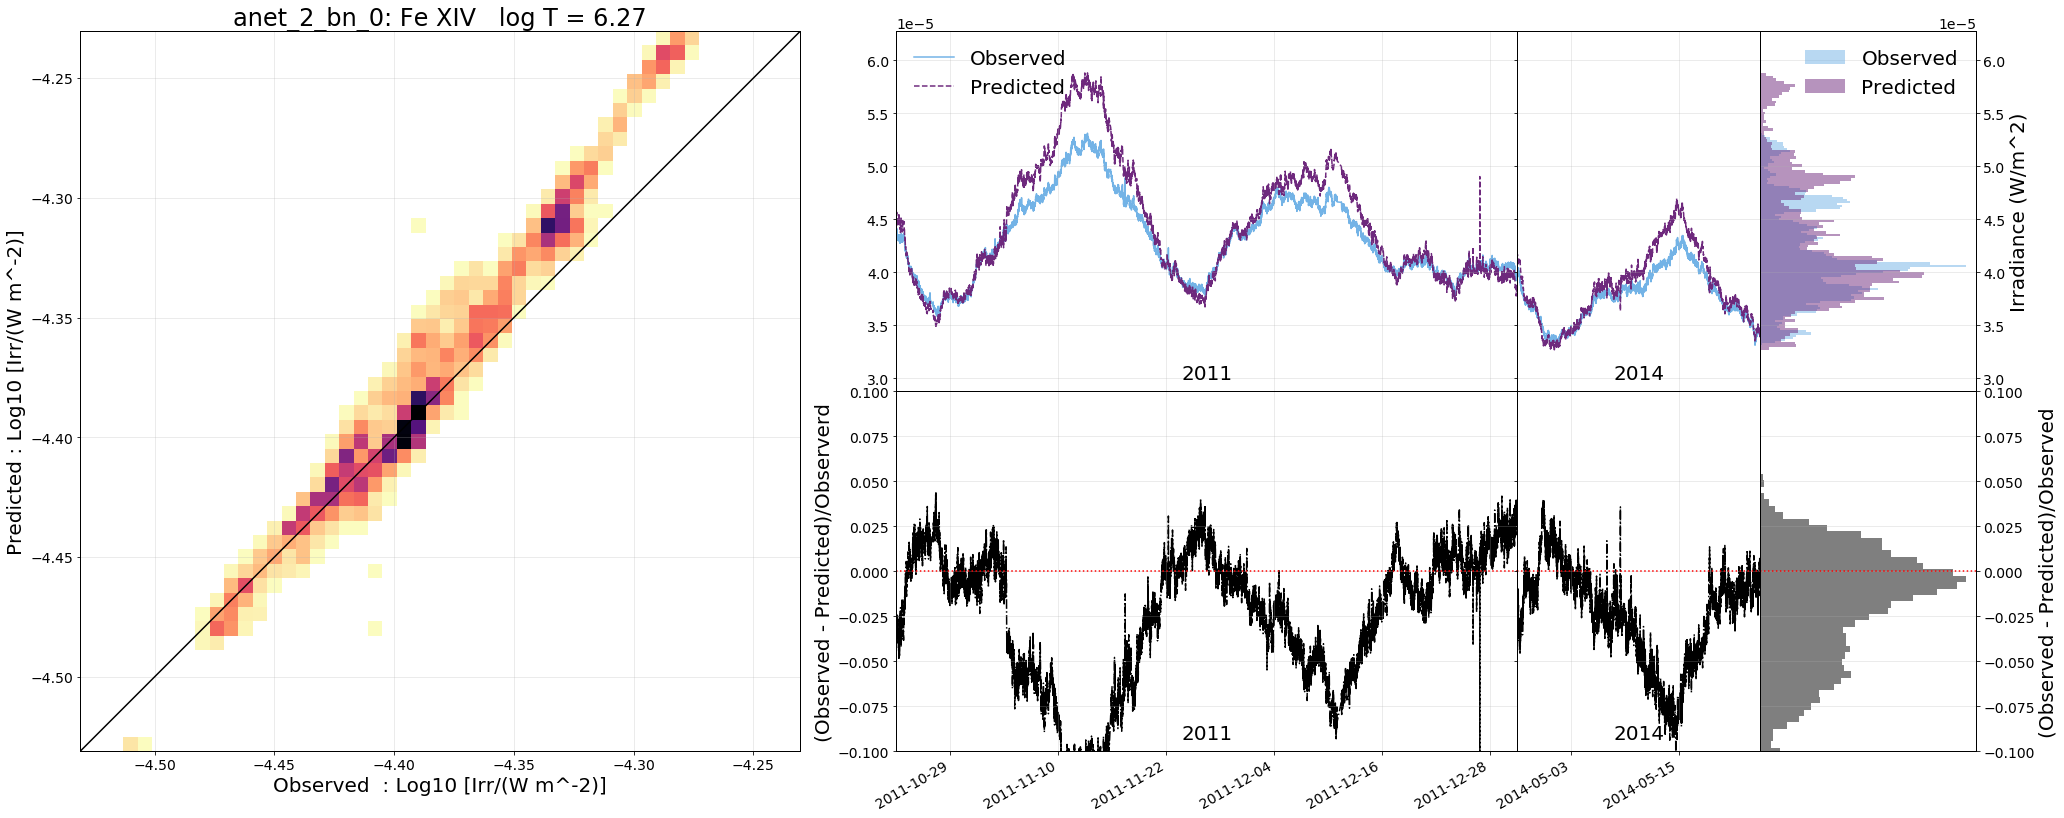

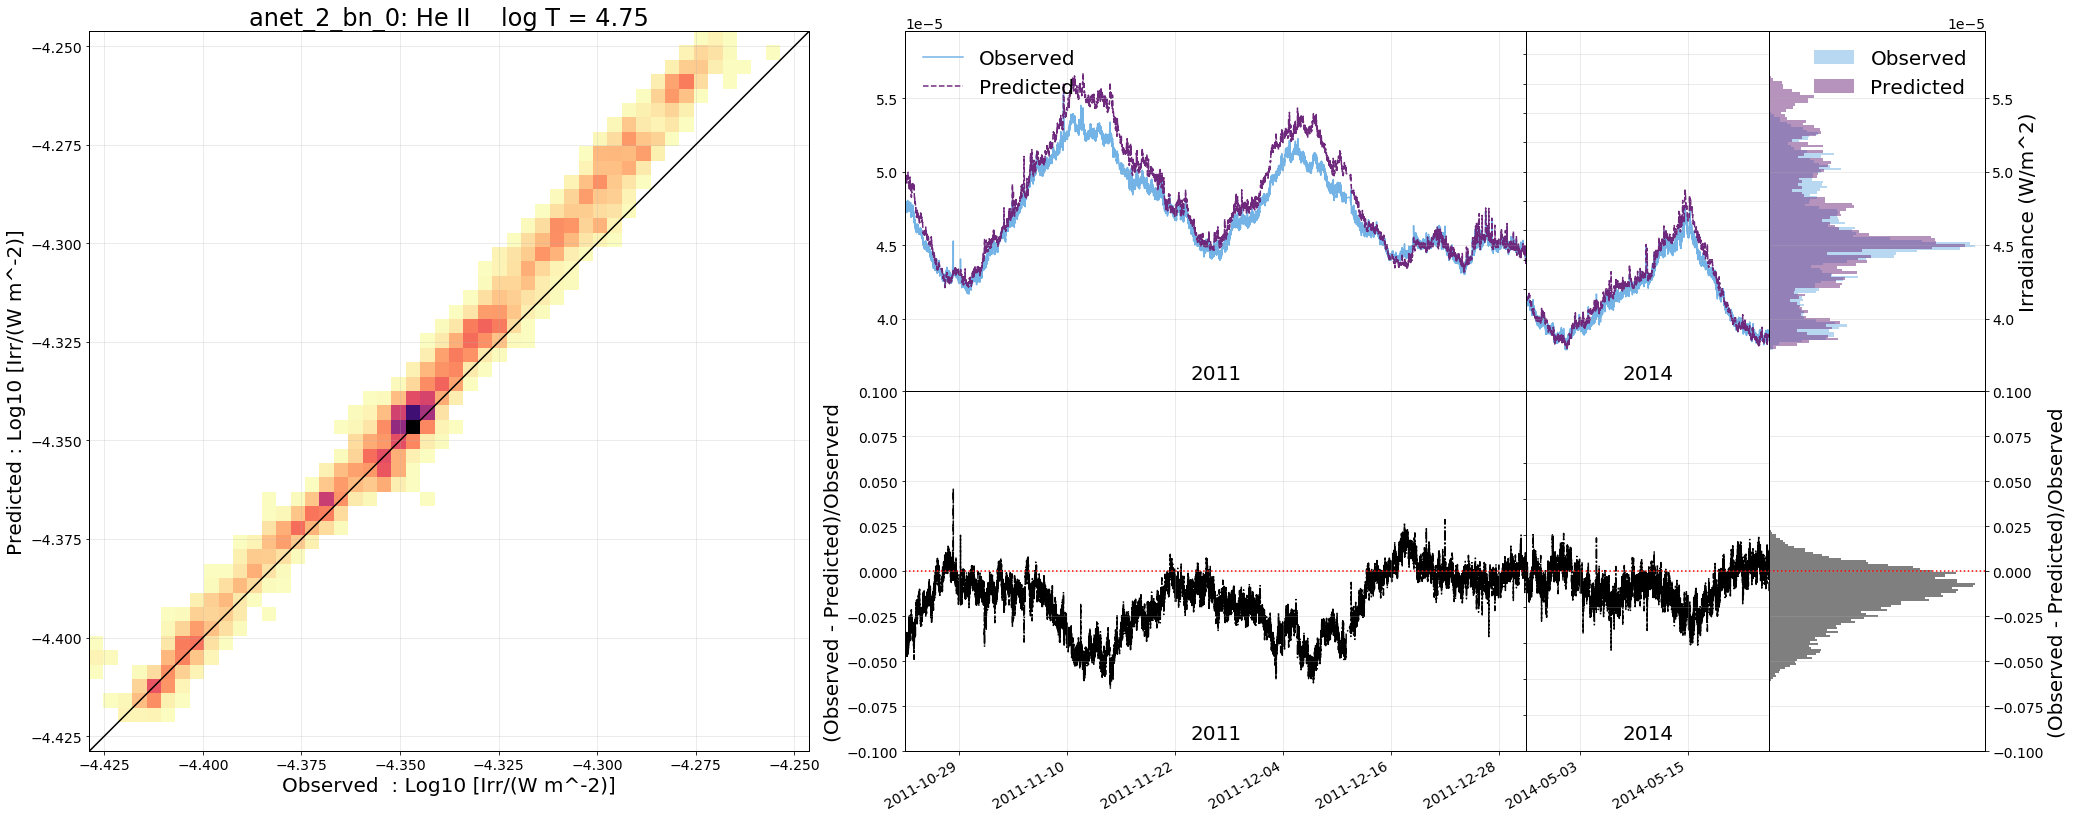

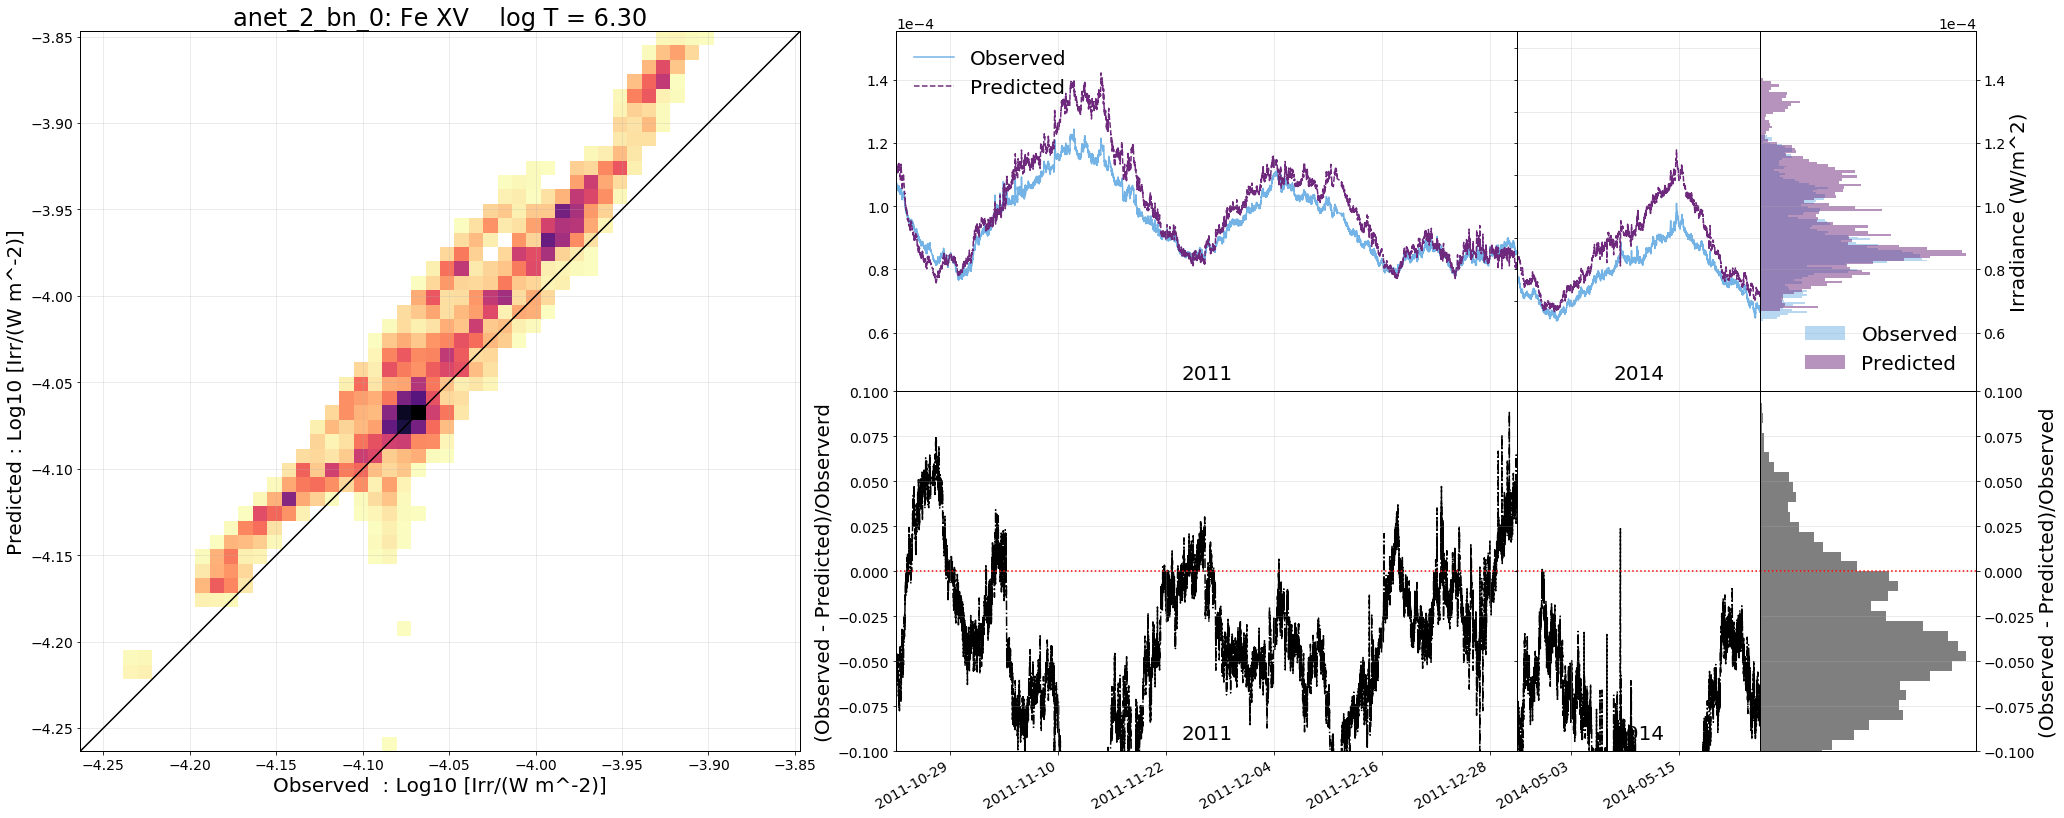

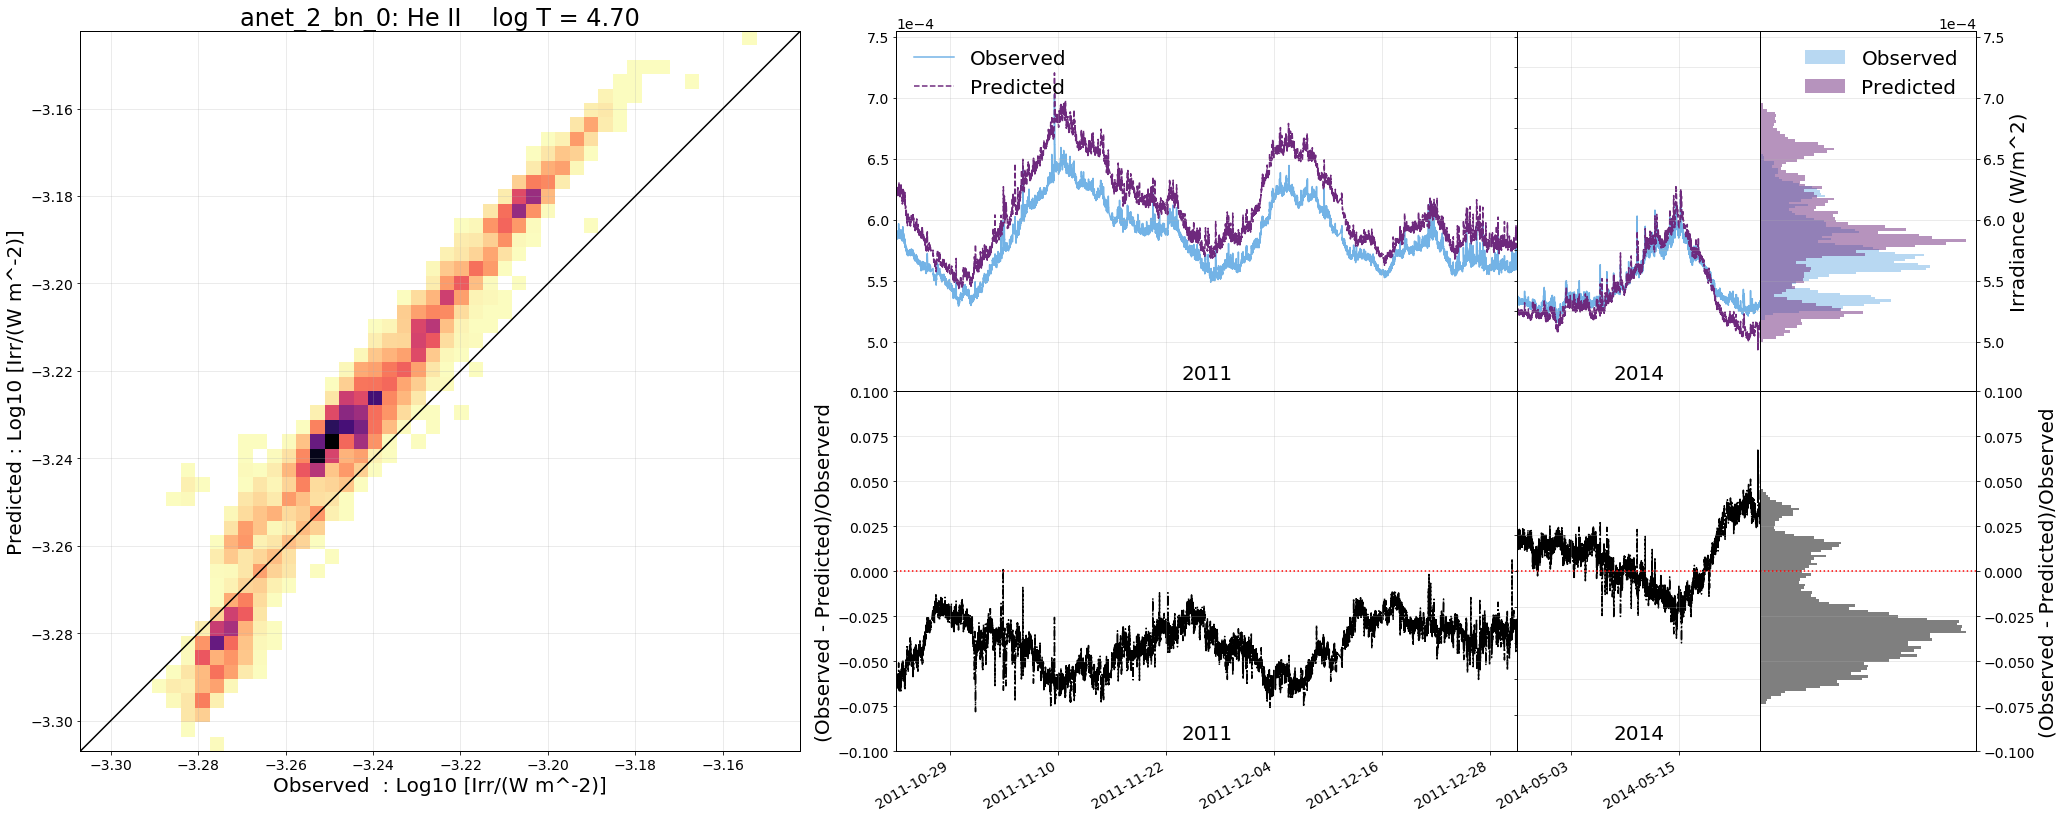

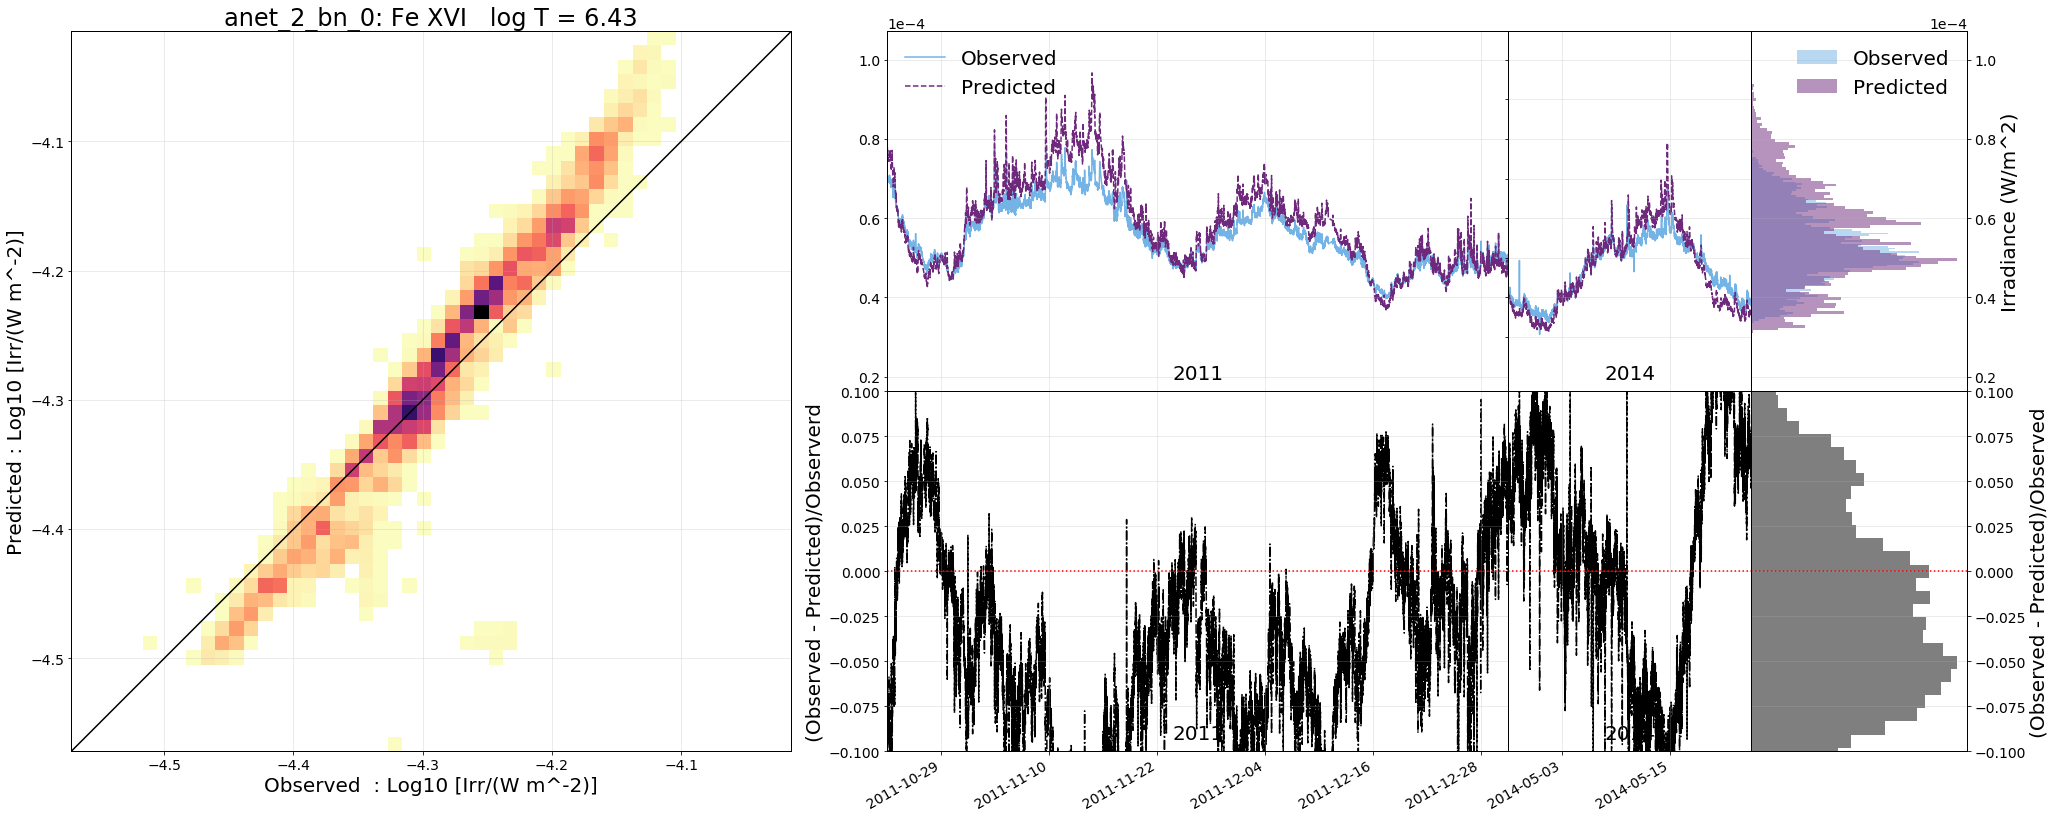

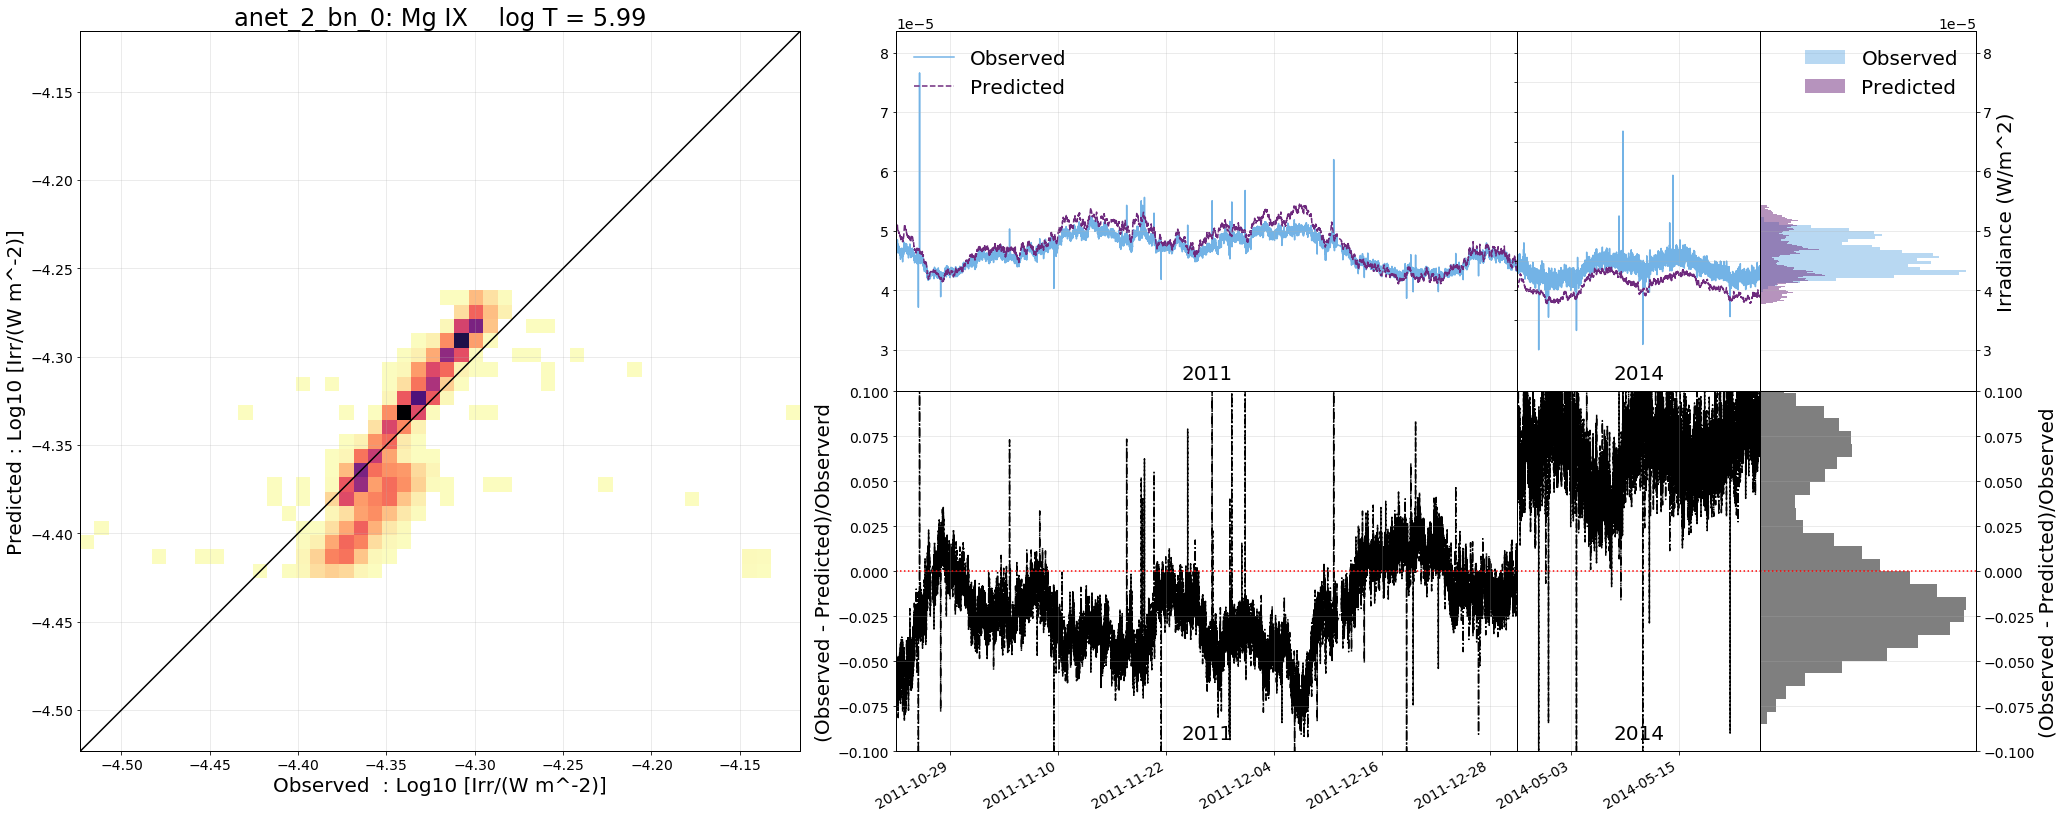

In [65]:
# Years to plot.  They must exist in the test data.  If you want to plot all data, and it has no gaps, leave it empty: years = np.array([])
years = np.array([2011,2014])

# Function to assemble the tick marks
toLabel = lambda t: t.round('D').strftime('%Y-%m-%d')
toLabelV = np.vectorize(toLabel)

nLabels = 8

# Size definitions
dpi = 300
pxx = 4500   # Horizontal size of each panel
pxy = 1500   # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 2      # Number of vertical panels
frc = 0.8    # Fraction of the panel devoted to histograms

# Padding
padv  = 300 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 400 #Horizontal padding in pixels at the edge of the figure
padh2 = 400 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (2*pxy + nph*pxx + 2*padh + (nph)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units

ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


for i in range(len(lines)):
    
    d = pd.DataFrame(eve[:,i],index=pd.to_datetime(iso),columns=['obs'])
    d['pred'] = eve[:,i]*(1.0-error[:,i])
    d['relerror'] = (d['obs']-d['pred'])/d['obs']

    # Cleaning input
    d = d[np.isfinite(d['pred'])]
    d = d[np.isfinite(d['obs'])]

    # Spurious observation
    date_l = datetime.datetime.strptime('2014-05-24T00:00:00', '%Y-%m-%dT%H:%M:%S')
    d = d[d.index<date_l]

    ## Start Figure
    fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

    ylim1 = np.max([np.max(d['obs']),np.max(d['pred'])])
    ylim2 = np.min([np.min(d['obs']),np.min(d['pred'])])
    
    # Enlarging image space to clear the histogram legend
    axiwdth = ylim1-ylim2

    ylim1 = ylim1 + 0.15*axiwdth
    ylim2 = ylim2 - 0.15*axiwdth
    
    if years.shape[0] == 0:

        totalT = np.array((d.index[-1].date()-d.index[0].date()).total_seconds())
        deltaLabels = datetime.timedelta(seconds=(totalT/nLabels).astype(float))    

        ax1 = fig.add_axes([ppadh + ppadh2 + 2*pxy/fszh, ppadv + pxy/fszv, pxx/fszh*frc, pxy/fszv])
        ax1.plot(d.index,d['obs'], zorder=1, color = Clr[4])
        ax1.plot(d.index,d['pred'], zorder=1, color = Clr[2], linestyle = '--')
        ax1.set_ylabel('Irradiance (W/m^2)')
        ax1.set_xticklabels([])
        leg = ax1.legend(('Observed', 'Predicted'),fontsize=20, frameon=False, columnspacing=1, loc = 2)

        ax1.set_xticks(d.index[0]+ (np.arange(0,nLabels)+0.5)*deltaLabels)
        ax1.set_xlim(left = d.index[0], right = d.index[-1])
        ax1.set_ylim(top = ylim1, bottom = ylim2)

        ax2 = fig.add_axes([ppadh + pxx/fszh*frc + ppadh2 + 2*pxy/fszh, ppadv + pxy/fszv, pxx/fszh*(1-frc), pxy/fszv], sharey = ax1)

    else:
        # Calculating scale rations for having the same xscale
        yrRat = years*0
        for yr in np.arange(0,years.shape[0]):
            date_1 = datetime.datetime.strptime('%d-01-01T00:00:00' % (years[yr]), '%Y-%m-%dT%H:%M:%S')
            date_2 = datetime.datetime.strptime('%d-12-31T00:00:00' % (years[yr]), '%Y-%m-%dT%H:%M:%S')
            tmp_d = d[np.logical_and(d.index>=date_1,d.index<=date_2)].copy()

            yrRat[yr] = (tmp_d.index[-1].date()-tmp_d.index[0].date()).total_seconds()

        totalT = np.sum(yrRat)
        yrRat = yrRat/totalT
        deltaLabels = datetime.timedelta(seconds=(totalT/nLabels).astype(float))

        for yr in np.arange(0,years.shape[0]):

            date_1 = datetime.datetime.strptime('%d-01-01T00:00:00' % (years[yr]), '%Y-%m-%dT%H:%M:%S')
            date_2 = datetime.datetime.strptime('%d-12-31T00:00:00' % (years[yr]), '%Y-%m-%dT%H:%M:%S')
            tmp_d = d[np.logical_and(d.index>=date_1,d.index<=date_2)].copy()

            shift = 0
            if yr != 0:
                shift = pxx/fszh*frc*np.sum(yrRat[0:yr])

            ax1 = fig.add_axes([ppadh + ppadh2 + 2*pxy/fszh + shift, ppadv + pxy/fszv, pxx/fszh*frc*yrRat[yr], pxy/fszv])
            ax1.plot(tmp_d.index,tmp_d['obs'], zorder=1, color = Clr[4])
            ax1.plot(tmp_d.index,tmp_d['pred'], zorder=1, color = Clr[2], linestyle = '--')
            ax1.set_xticklabels([])

            if(tmp_d.shape[0]>0):
                ax1.set_xticks(tmp_d.index[0]+ (np.arange(0,nLabels)+0.5)*deltaLabels)
                ax1.set_xlim(left = tmp_d.index[0], right = tmp_d.index[-1])

            if yr == 0:
                leg = ax1.legend(('Observed', 'Predicted'),fontsize=20, frameon=False, columnspacing=1, loc = 2)
                yticks = ax1.get_yticks()
                ax2 = fig.add_axes([ppadh + pxx/fszh*frc + ppadh2 + 2*pxy/fszh, ppadv + pxy/fszv, pxx/fszh*(1-frc), pxy/fszv], sharey = ax1)
            else:
                ax1.set_yticks(yticks)
                ax1.set_yticklabels([]) 

            ax1.set_ylim(top = ylim1, bottom = ylim2)
            ax1.text(0.5,0.05, '%d' % (years[yr]), fontsize = 20 , horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)


    ax2.hist(d['obs'], orientation = 'horizontal', alpha = 0.5, bins = 100, color = Clr[4])
    ax2.hist(d['pred'], orientation = 'horizontal', alpha = 0.5, bins = 100, color = Clr[2])
    ax2.yaxis.set_label_position('right')
    ax2.yaxis.tick_right()
    ax2.ticklabel_format(style = 'sci', scilimits = (0,0))
    ax2.set_ylabel('Irradiance (W/m^2)')
    ax2.set_xticks([])
    leg = ax2.legend(('Observed', 'Predicted'),fontsize=20, frameon=False, columnspacing=1)


    ylim = 0.1#np.max([np.abs(np.min(d['relerror'])), np.abs(np.max(d['relerror']))])


    if years.shape[0] == 0:

        ax3 = fig.add_axes([ppadh + ppadh2 + 2*pxy/fszh, ppadv, pxx/fszh*frc, pxy/fszv])
        ax3.plot(d.index,d['relerror'], zorder=1, color = 'k', linestyle = '-.')
        ax3.set_ylabel('(Observed - Predicted)/Observerd')
        ax3.plot(ax1.get_xbound(), [0, 0], color = 'r', linestyle = ':')
        ax3.set_xlim(left = d.index[0], right = d.index[-1])
        ax3.set_ylim(top = ylim, bottom = -ylim)

        ax3.set_xticks(d.index[0]+ (np.arange(0,nLabels)+0.5)*deltaLabels)
        ax3.set_xticklabels(toLabelV(d.index[0]+ (np.arange(0,nLabels)+0.5)*deltaLabels))
        ax3.set_xlim(left = d.index[0], right = d.index[-1])
        plt.setp(ax3.get_xticklabels(), visible=True, rotation=30, ha='right')

        ax4 = fig.add_axes([ppadh + pxx/fszh*frc + ppadh2 + 2*pxy/fszh, ppadv, pxx/fszh*(1-frc), pxy/fszv], sharey = ax3)

    else:

        for yr in np.arange(0,years.shape[0]):

            date_1 = datetime.datetime.strptime('%d-01-01T00:00:00' % (years[yr]), '%Y-%m-%dT%H:%M:%S')
            date_2 = datetime.datetime.strptime('%d-12-31T00:00:00' % (years[yr]), '%Y-%m-%dT%H:%M:%S')
            tmp_d = d[np.logical_and(d.index>=date_1,d.index<=date_2)].copy()

            shift = 0
            if yr != 0:
                shift = pxx/fszh*frc*np.sum(yrRat[0:yr])        

            ax3 = fig.add_axes([ppadh + ppadh2 + 2*pxy/fszh + shift, ppadv, pxx/fszh*frc*yrRat[yr], pxy/fszv])
            ax3.plot(tmp_d.index,tmp_d['relerror'], zorder=1, color = 'k', linestyle = '-.')
            ax3.plot([tmp_d.index[1],tmp_d.index[-1]], [0, 0], color = 'r', linestyle = ':')


            if(tmp_d.shape[0]>0):
                ax3.set_xticks(tmp_d.index[0]+ (np.arange(0,nLabels)+0.5)*deltaLabels)
                ax3.set_xticklabels(toLabelV(tmp_d.index[0]+ (np.arange(0,nLabels)+0.5)*deltaLabels))
                ax3.set_xlim(left = tmp_d.index[0], right = tmp_d.index[-1])

            if yr == 0:
                ax3.set_ylabel('(Observed - Predicted)/Observerd')
                yticks = ax3.get_yticks()
                ax4 = fig.add_axes([ppadh + pxx/fszh*frc + ppadh2 + 2*pxy/fszh, ppadv, pxx/fszh*(1-frc), pxy/fszv], sharey = ax3)
            else:
                ax3.set_yticklabels([])
                ax3.set_yticks(yticks)

            ax3.set_ylim(top = ylim, bottom = -ylim)
            plt.setp(ax3.get_xticklabels(), visible=True, rotation=30, ha='right')
            ax3.text(0.5,0.05, '%d' % (years[yr]), fontsize = 20 , horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)


    his = ax4.hist(d['relerror'], orientation = 'horizontal', alpha = 0.5, bins = 100, color = 'k')
    ax4.plot([0, np.max(his[0])*1.05], [0, 0], color = 'r', linestyle = ':')
    ax4.set_xticks([])
    ax4.yaxis.set_label_position('right')
    ax4.yaxis.tick_right()
    ax4.set_ylabel('(Observed - Predicted)/Observed')
    ax4.set_xlim(left = 0, right = np.max(his[0])*1.05)
    ax4.set_ylim(top = ylim, bottom = -ylim)


    ax5 = fig.add_axes([ppadh, ppadv, 2*pxy/fszh, 2*pxy/fszv])

    r1 = np.min([np.min(np.log10(eve[:,i])), np.min(np.log10(eve[:,i]*(1.0-error[:,i])))])
    r2 = np.max([np.max(np.log10(eve[:,i])), np.max(np.log10(eve[:,i]*(1.0-error[:,i])))])
    hrange = [[r1,r2], [r1, r2]]
    ax5.hist2d(np.log10(eve[:,i]), np.log10(eve[:,i]*(1.0-error[:,i])), range=hrange, bins=[50,50], cmap=plt.cm.magma_r,cmin=1)
    ax5.plot([r1,r2],[r1,r2])
    ax5.set_xlabel('Observed  : Log10 [Irr/(W m^-2)]')
    ax5.set_ylabel('Predicted : Log10 [Irr/(W m^-2)]')
    ax5.set_title('{0}: {1} log T = {2:.2f}'.format(modelname,name[i],logT[i]))
    
    fig.savefig(patho+'{0}_logT{1:.2f}_{2}_timeplot.png'.format(modelname,logT[i],name[i].replace(' ','_')))
    

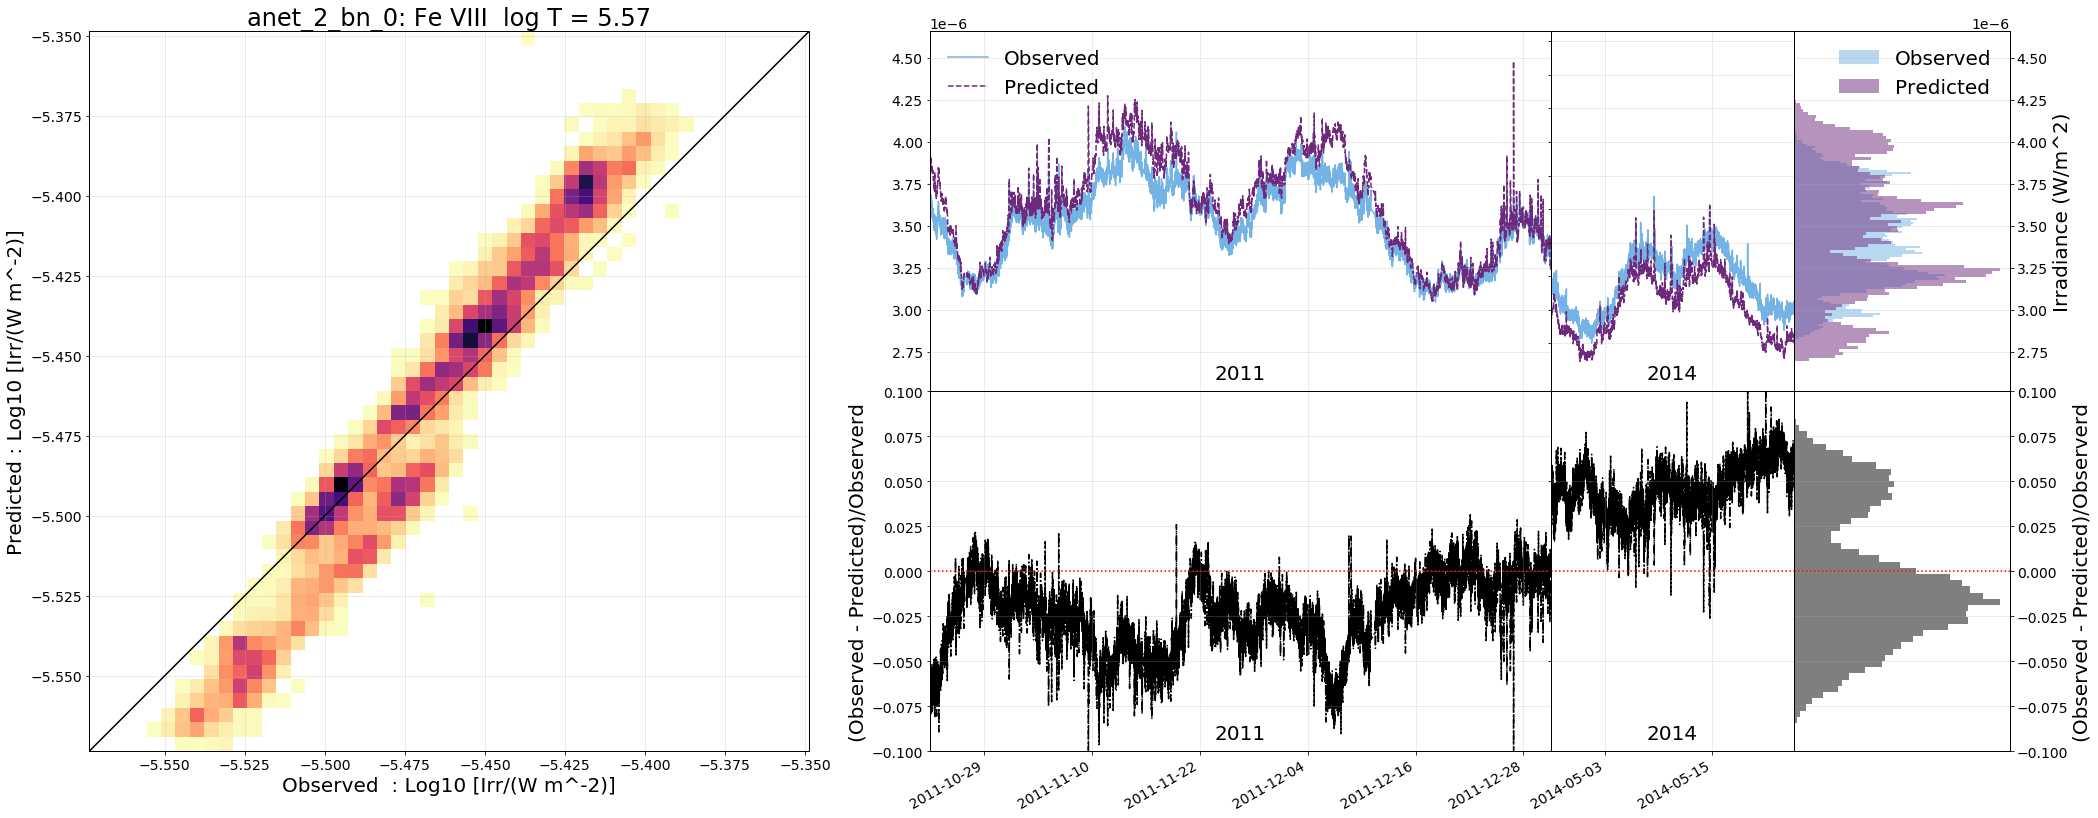

In [64]:
# Years to plot.  They must exist in the test data.  If you want to plot all data, and it has no gaps, leave it empty: years = np.array([])
years = np.array([2011,2014])

toLabel = lambda t: t.round('D').strftime('%Y-%m-%d')
toLabelV = np.vectorize(tostring)

nLabels = 8

# Size definitions
dpi = 300
pxx = 4500   # Horizontal size of each panel
pxy = 1500   # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 2      # Number of vertical panels
frc = 0.8    # Fraction of the panel devoted to histograms

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 200 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (2*pxy + nph*pxx + 2*padh + (nph)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


i=1

d = pd.DataFrame(eve[:,i],index=pd.to_datetime(iso),columns=['obs'])
d['pred'] = eve[:,i]*(1.0-error[:,i])
d['relerror'] = (d['obs']-d['pred'])/d['obs']

# Cleaning input
d = d[np.isfinite(d['pred'])]
d = d[np.isfinite(d['obs'])]

# Spurious observation
date_l = datetime.datetime.strptime('2014-05-24T00:00:00', '%Y-%m-%dT%H:%M:%S')
d = d[d.index<date_l]

## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

ylim1 = np.max([np.max(d['obs']),np.max(d['pred'])])
ylim2 = np.min([np.min(d['obs']),np.min(d['pred'])])

# Enlarging image space to clear the histogram legend
axiwdth = ylim1-ylim2

ylim1 = ylim1 + 0.1*axiwdth
ylim2 = ylim2 - 0.1*axiwdth


if years.shape[0] == 0:
    
    totalT = np.array((d.index[-1].date()-d.index[0].date()).total_seconds())
    deltaLabels = datetime.timedelta(seconds=(totalT/nLabels).astype(float))    

    ax1 = fig.add_axes([ppadh + ppadh2 + 2*pxy/fszh, ppadv + pxy/fszv, pxx/fszh*frc, pxy/fszv])
    ax1.plot(d.index,d['obs'], zorder=1, color = Clr[4])
    ax1.plot(d.index,d['pred'], zorder=1, color = Clr[2], linestyle = '--')
    ax1.set_ylabel('Irradiance (W/m^2)')
    ax1.set_xticklabels([])
    leg = ax1.legend(('Observed', 'Predicted'),fontsize=20, frameon=False, columnspacing=1, loc = 2)
    
    ax1.set_xticks(d.index[0]+ (np.arange(0,nLabels)+0.5)*deltaLabels)
    ax1.set_xlim(left = d.index[0], right = d.index[-1])
    ax1.set_ylim(top = ylim1, bottom = ylim2)
    
    ax2 = fig.add_axes([ppadh + pxx/fszh*frc + ppadh2 + 2*pxy/fszh, ppadv + pxy/fszv, pxx/fszh*(1-frc), pxy/fszv], sharey = ax1)
    
else:
    # Calculating scale rations for having the same xscale
    yrRat = years*0
    for yr in np.arange(0,years.shape[0]):
        date_1 = datetime.datetime.strptime('%d-01-01T00:00:00' % (years[yr]), '%Y-%m-%dT%H:%M:%S')
        date_2 = datetime.datetime.strptime('%d-12-31T00:00:00' % (years[yr]), '%Y-%m-%dT%H:%M:%S')
        tmp_d = d[np.logical_and(d.index>=date_1,d.index<=date_2)].copy()
        
        yrRat[yr] = (tmp_d.index[-1].date()-tmp_d.index[0].date()).total_seconds()
    
    totalT = np.sum(yrRat)
    yrRat = yrRat/totalT
    deltaLabels = datetime.timedelta(seconds=(totalT/nLabels).astype(float))
    
    for yr in np.arange(0,years.shape[0]):
        
        date_1 = datetime.datetime.strptime('%d-01-01T00:00:00' % (years[yr]), '%Y-%m-%dT%H:%M:%S')
        date_2 = datetime.datetime.strptime('%d-12-31T00:00:00' % (years[yr]), '%Y-%m-%dT%H:%M:%S')
        tmp_d = d[np.logical_and(d.index>=date_1,d.index<=date_2)].copy()
        
        shift = 0
        if yr != 0:
            shift = pxx/fszh*frc*np.sum(yrRat[0:yr])
        
        ax1 = fig.add_axes([ppadh + ppadh2 + 2*pxy/fszh + shift, ppadv + pxy/fszv, pxx/fszh*frc*yrRat[yr], pxy/fszv])
        ax1.plot(tmp_d.index,tmp_d['obs'], zorder=1, color = Clr[4])
        ax1.plot(tmp_d.index,tmp_d['pred'], zorder=1, color = Clr[2], linestyle = '--')
        ax1.set_xticklabels([])
            
        if(tmp_d.shape[0]>0):
            ax1.set_xticks(tmp_d.index[0]+ (np.arange(0,nLabels)+0.5)*deltaLabels)
            ax1.set_xlim(left = tmp_d.index[0], right = tmp_d.index[-1])
                
        if yr == 0:
            leg = ax1.legend(('Observed', 'Predicted'),fontsize=20, frameon=False, columnspacing=1, loc = 2)
            yticks = ax1.get_yticks()
            ax2 = fig.add_axes([ppadh + pxx/fszh*frc + ppadh2 + 2*pxy/fszh, ppadv + pxy/fszv, pxx/fszh*(1-frc), pxy/fszv], sharey = ax1)
        else:
            ax1.set_yticks(yticks)
            ax1.set_yticklabels([])
            
        ax1.text(0.5,0.05, '%d' % (years[yr]), fontsize = 20 , horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
        ax1.set_ylim(top = ylim1, bottom = ylim2)


ax2.hist(d['obs'], orientation = 'horizontal', alpha = 0.5, bins = 100, color = Clr[4])
ax2.hist(d['pred'], orientation = 'horizontal', alpha = 0.5, bins = 100, color = Clr[2])
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.ticklabel_format(style = 'sci', scilimits = (0,0))
ax2.set_ylabel('Irradiance (W/m^2)')
ax2.set_xticks([])
leg = ax2.legend(('Observed', 'Predicted'),fontsize=20, frameon=False, columnspacing=1)


ylim = 0.1#np.max([np.abs(np.min(d['relerror'])), np.abs(np.max(d['relerror']))])


if years.shape[0] == 0:

    ax3 = fig.add_axes([ppadh + ppadh2 + 2*pxy/fszh, ppadv, pxx/fszh*frc, pxy/fszv])
    ax3.plot(d.index,d['relerror'], zorder=1, color = 'k', linestyle = '-.')
    ax3.set_ylabel('(Observed - Predicted)/Observerd')
    ax3.plot(ax1.get_xbound(), [0, 0], color = 'r', linestyle = ':')
    ax3.set_xlim(left = d.index[0], right = d.index[-1])
    ax3.set_ylim(top = ylim, bottom = -ylim)
    
    ax3.set_xticks(d.index[0]+ (np.arange(0,nLabels)+0.5)*deltaLabels)
    ax3.set_xticklabels(toLabelV(d.index[0]+ (np.arange(0,nLabels)+0.5)*deltaLabels))
    ax3.set_xlim(left = d.index[0], right = d.index[-1])
    plt.setp(ax3.get_xticklabels(), visible=True, rotation=30, ha='right')
    
    ax4 = fig.add_axes([ppadh + pxx/fszh*frc + ppadh2 + 2*pxy/fszh, ppadv, pxx/fszh*(1-frc), pxy/fszv], sharey = ax3)

else:
    
    for yr in np.arange(0,years.shape[0]):
        
        date_1 = datetime.datetime.strptime('%d-01-01T00:00:00' % (years[yr]), '%Y-%m-%dT%H:%M:%S')
        date_2 = datetime.datetime.strptime('%d-12-31T00:00:00' % (years[yr]), '%Y-%m-%dT%H:%M:%S')
        tmp_d = d[np.logical_and(d.index>=date_1,d.index<=date_2)].copy()
        
        shift = 0
        if yr != 0:
            shift = pxx/fszh*frc*np.sum(yrRat[0:yr])        
        
        ax3 = fig.add_axes([ppadh + ppadh2 + 2*pxy/fszh + shift, ppadv, pxx/fszh*frc*yrRat[yr], pxy/fszv])
        ax3.plot(tmp_d.index,tmp_d['relerror'], zorder=1, color = 'k', linestyle = '-.')
        ax3.plot([tmp_d.index[1],tmp_d.index[-1]], [0, 0], color = 'r', linestyle = ':')
        
        
        if(tmp_d.shape[0]>0):
            ax3.set_xticks(tmp_d.index[0]+ (np.arange(0,nLabels)+0.5)*deltaLabels)
            ax3.set_xticklabels(toLabelV(tmp_d.index[0]+ (np.arange(0,nLabels)+0.5)*deltaLabels))
            ax3.set_xlim(left = tmp_d.index[0], right = tmp_d.index[-1])
                
        if yr == 0:
            ax3.set_ylabel('(Observed - Predicted)/Observerd')
            yticks = ax3.get_yticks()
            ax4 = fig.add_axes([ppadh + pxx/fszh*frc + ppadh2 + 2*pxy/fszh, ppadv, pxx/fszh*(1-frc), pxy/fszv], sharey = ax3)
        else:
            ax3.set_yticklabels([])
            ax3.set_yticks(yticks)
            
        ax3.text(0.5,0.05, '%d' % (years[yr]), fontsize = 20 , horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)
            
        ax3.set_ylim(top = ylim, bottom = -ylim)
        plt.setp(ax3.get_xticklabels(), visible=True, rotation=30, ha='right')
        

his = ax4.hist(d['relerror'], orientation = 'horizontal', alpha = 0.5, bins = 100, color = 'k')
ax4.plot([0, np.max(his[0])*1.05], [0, 0], color = 'r', linestyle = ':')
ax4.set_xticks([])
ax4.yaxis.set_label_position('right')
ax4.yaxis.tick_right()
ax4.set_ylabel('(Observed - Predicted)/Observerd')
ax4.set_xlim(left = 0, right = np.max(his[0])*1.05)
ax4.set_ylim(top = ylim, bottom = -ylim)


ax5 = fig.add_axes([ppadh, ppadv, 2*pxy/fszh, 2*pxy/fszv])

r1 = np.min([np.min(np.log10(eve[:,i])), np.min(np.log10(eve[:,i]*(1.0-error[:,i])))])
r2 = np.max([np.max(np.log10(eve[:,i])), np.max(np.log10(eve[:,i]*(1.0-error[:,i])))])
hrange = [[r1,r2], [r1, r2]]
ax5.hist2d(np.log10(eve[:,i]), np.log10(eve[:,i]*(1.0-error[:,i])), range=hrange, bins=[50,50], cmap=plt.cm.magma_r,cmin=1)
ax5.plot([r1,r2],[r1,r2])
ax5.set_xlabel('Observed  : Log10 [Irr/(W m^-2)]')
ax5.set_ylabel('Predicted : Log10 [Irr/(W m^-2)]')
ax5.set_title('{0}: {1} log T = {2:.2f}'.format(modelname,name[i],logT[i]))

plt.show()

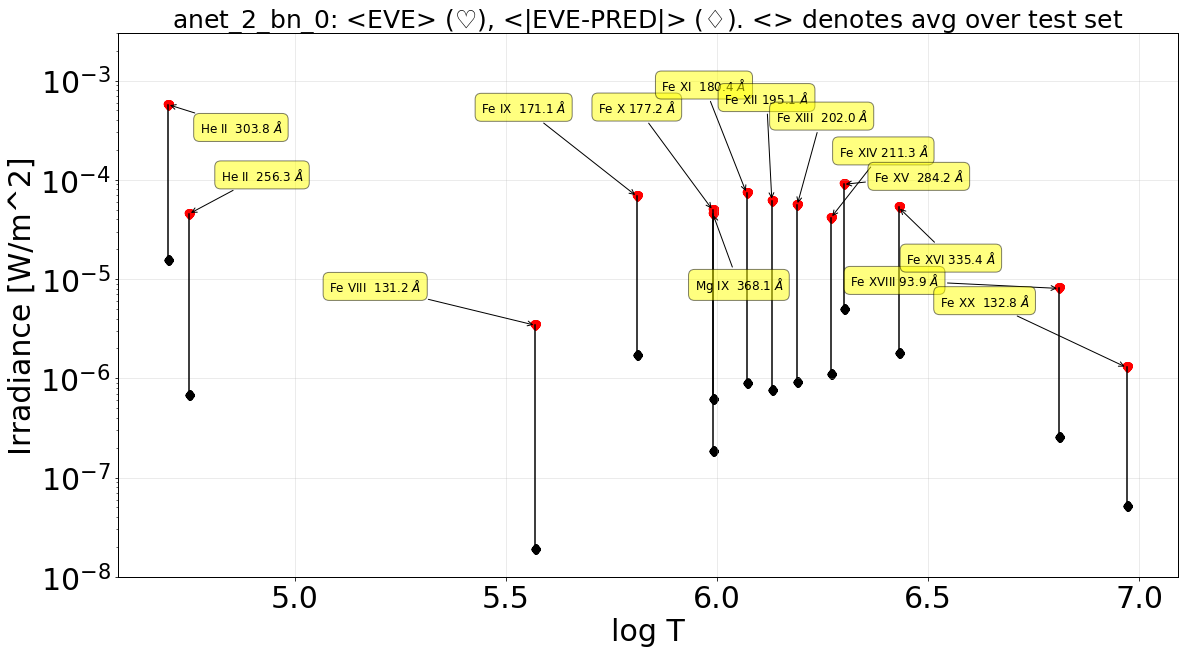

In [43]:
fig,ax=plt.subplots(figsize=(19,10))
plt.scatter(logT, abs(mean_error), marker=r'$\diamondsuit$', linewidth=5)
plt.scatter(logT, eve.mean(axis=0), marker=r'$\heartsuit$', linewidth=5, color='red')
fig.markersize=20
plt.yscale('log')
plt.ylim(1e-8,3e-3)
ax.set_xlabel('log T',fontsize=30)
ax.set_ylabel('Irradiance [W/m^2]', fontsize=30)
ax.tick_params(labelsize=30)
plt.title('{0}: <EVE> ($\heartsuit$), <|EVE-PRED|> ($\diamondsuit$). <> denotes avg over test set'.format(modelname),
          fontsize=25)
for i in range(logT.shape[0]):
    plt.plot([logT[i],logT[i]],[abs(mean_error[i]),eve[:,i].mean()], color='black')
    plt.annotate(name[i].replace('  ','')+' {0:.1f} $\AA$'.format(wavelength[i]*10.0), xy=(logT[i], eve[:,i].mean()), 
                 xytext=(-120*np.cos(i/10*np.pi),100*np.sin(i/10*np.pi)),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'),fontsize=12)

plt.savefig(patho+modelname+'_Err_vs_LogT.png')

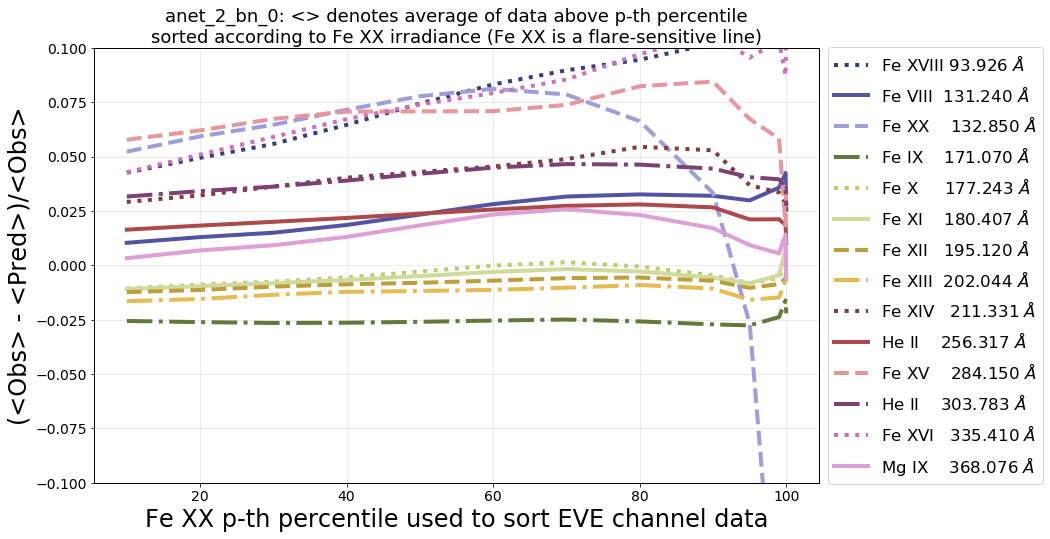

In [66]:
metstr = 'logT '
wavelength


# In[243]:


struct = {'mean_eve':eve.mean(axis=0), 'mean_error': mean_error, 'mean_rel_error': ((pred-eve)/eve).mean(axis=0),
          'logT':logT, 'wavelength':wavelength, 'name':name}



# In[270]:


percentiles = np.array([10,20,30,40,50,60,70,80,90,95,99,99.9,99.99])
evep = np.zeros([percentiles.shape[0],eve.shape[1]])
predp = np.zeros([percentiles.shape[0],eve.shape[1]])
counter=0
for p in percentiles:
    per = np.percentile(eve[:,2],p)
    ind = np.array(np.where(eve[:,2] >= per))
    evep[counter,:] = eve[ind,:].mean(axis=1)
    predp[counter,:]= pred[ind,:].mean(axis=1)    
    #print(p,per,eve[ind,2].mean(),pred[ind,2].mean())
    counter=counter + 1

from matplotlib import cm
from numpy import linspace

start = 0.0
stop = 1.0
number_of_lines= eve.shape[1]
cm_subsection = np.linspace(start, stop, number_of_lines) 

colors = [ cm.tab20b(x) for x in cm_subsection ]
linestyle = [':','-','--','-.']
#for i in range(eve.shape[1]):
fig,ax=plt.subplots(figsize=(13,8))
for i in range(number_of_lines):
    plt.plot(percentiles,predp[:,i]/evep[:,i]-1,linewidth=4,color=colors[i],linestyle=linestyle[np.mod(i,4)])\

plt.xlabel('Fe XX p-th percentile used to sort EVE channel data', fontsize=24)
plt.ylabel('(<Obs> - <Pred>)/<Obs>', fontsize=24)
plt.ylim(-ylim,ylim)
plt.title(modelname+": <> denotes average of data above p-th percentile\nsorted according to Fe XX irradiance (Fe XX is a flare-sensitive line)", fontsize=18)
plt.legend(['{0} {1:.3f} $\AA$'.format(name[x],wavelength[x]*10) for x in range(number_of_lines)], loc='center left', bbox_to_anchor=(1, 0.5), labelspacing = 0.65)
plt.savefig(patho+modelname+'_percentiles.png', bbox_inches = 'tight')